In [10]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import json
from datetime import datetime
from torch.nn.utils import clip_grad_norm_


# Import from previous notebooks
# (Use %run or import directly if you've created Python modules)
%run "01-data-preperation.ipynb"  # For data loaders
%run "02-model-implementation.ipynb"  # For model definitions

# Set up directories for saving results
base_dir = "results"
model_dir = os.path.join(base_dir, "models")
log_dir = os.path.join(base_dir, "logs")
plot_dir = os.path.join(base_dir, "plots")

# Create directories if they don't exist
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda:0
Dataset loaded with 45000 training, 5000 validation, and 10000 test images.
Number of classes: 10
Using device: cuda

Testing ResNet-18 variants:
Basic ResNet-18:
Input shape: torch.Size([1, 3, 32, 32]), Output shape: torch.Size([1, 10])

SE-ResNet-18:
Input shape: torch.Size([1, 3, 32, 32]), Output shape: torch.Size([1, 10])

CBAM-ResNet-18:
Input shape: torch.Size([1, 3, 32, 32]), Output shape: torch.Size([1, 10])

Parameter counts:
ResNet-18: 11,173,962 parameters
SE-ResNet-18: 11,261,002 parameters
CBAM-ResNet-18: 11,261,786 parameters
SE-ResNet-18 has 0.78% more parameters than base
CBAM-ResNet-18 has 0.79% more parameters than base

Testing ResNet-34 variants:
Basic ResNet-34:
Input shape: torch.Size([1, 3, 32, 32]), Output shape: torch.Size([1, 10])

SE-ResNet-34:
Input shape: torch.Size([1, 3, 32, 32]), Output shape: torch.Size([1, 10])

CBAM-ResNet-34:
Input shape: torch.Size([1, 3, 32, 32]), Output shape: torch.Size([1, 10])

Parameter counts:
ResNet-34: 

In [14]:
# Define hyperparameters
config = {
    # Common training parameters
    "num_epochs": 100,
    "batch_size": 128,
    "learning_rate": 0.01,  
    "weight_decay": 5e-4,
    "early_stopping_patience": 15,
    "scheduler_step_size": 30,
    "scheduler_gamma": 0.1,
    
    # Add optimizer settings
    "optimizer": "sgd",
    "momentum": 0.9,
    
    # Add some needed keys
    "logging": {
        "save_dir": "checkpoints",
        "log_dir": "logs"
    },
    
    # Model-specific parameters
    "models": {
        "resnet18": {
            "base": {"learning_rate": 0.01},
            "se": {"learning_rate": 0.01, "reduction_ratio": 16},
            "cbam": {"learning_rate": 0.01, "reduction_ratio": 16}
        }
    }
}

# Save configuration for reproducibility
with open(os.path.join(log_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

In [15]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler=None, clip_value=None, device='cuda'):
    """
    Train for one epoch with enhanced metrics and monitoring
    
    Args:
        model: The neural network model
        dataloader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler (optional)
        clip_value: Gradient clipping threshold (optional)
        device: Device to use for training ('cuda' or 'cpu')
        
    Returns:
        dict: Dictionary containing all metrics
    """
    model.train()
    start_time = time.time()
    
    running_loss = 0.0
    running_corrects = 0
    running_top5_corrects = 0
    processed_size = 0
    batch_times = []
    grad_norms = []
    
    # Get initial memory usage
    initial_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        batch_start = time.time()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Calculate top-5 accuracy
        _, top5_preds = torch.topk(outputs, 5, dim=1)
        correct_top5 = 0
        for i, label in enumerate(labels):
            correct_top5 += (label == top5_preds[i]).any().item()
        
        # Backward pass and optimize
        loss.backward()
        
        # Track gradient norms
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        grad_norms.append(total_norm)
        
        # Apply gradient clipping if specified
        if clip_value is not None:
            clip_grad_norm_(model.parameters(), clip_value)
        
        optimizer.step()
        
        # Update learning rate if scheduler is provided
        if scheduler is not None and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()
            
        # Statistics
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(preds == labels.data).item()
        running_top5_corrects += correct_top5
        processed_size += batch_size
        
        # Track batch processing time
        batch_times.append(time.time() - batch_start)
    
    # Calculate metrics
    epoch_loss = running_loss / processed_size
    epoch_acc = running_corrects / processed_size
    epoch_top5_acc = running_top5_corrects / processed_size
    epoch_time = time.time() - start_time
    avg_batch_time = np.mean(batch_times)
    avg_grad_norm = np.mean(grad_norms)
    
    # Calculate peak memory usage
    peak_memory = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
    memory_usage = peak_memory - initial_memory
    
    # Update learning rate for epoch-based schedulers
    if scheduler is not None and not isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
        scheduler.step()
    
    # Return all metrics
    metrics = {
        'loss': epoch_loss,
        'acc': epoch_acc,
        'top5_acc': epoch_top5_acc,
        'time': epoch_time,
        'avg_batch_time': avg_batch_time,
        'memory_usage': memory_usage,
        'avg_grad_norm': avg_grad_norm,
        'current_lr': optimizer.param_groups[0]['lr']
    }
    
    return metrics


def evaluate(model, dataloader, criterion, device='cuda'):
    """
    Evaluate the model with enhanced metrics
    
    Args:
        model: The neural network model
        dataloader: Validation/test data loader
        criterion: Loss function
        device: Device to use for evaluation ('cuda' or 'cpu')
        
    Returns:
        dict: Dictionary containing all metrics
    """
    model.eval()
    start_time = time.time()
    
    running_loss = 0.0
    running_corrects = 0
    running_top5_corrects = 0
    processed_size = 0
    
    # Store predictions and targets for confusion matrix
    all_preds = []
    all_labels = []
    class_correct = {}
    class_total = {}
    
    # Get initial memory usage
    initial_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else 0
    
    inference_times = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Measure inference time
            inf_start = time.time()
            outputs = model(inputs)
            inference_times.append(time.time() - inf_start)
            
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Calculate top-5 accuracy
            _, top5_preds = torch.topk(outputs, 5, dim=1)
            correct_top5 = 0
            for i, label in enumerate(labels):
                correct_top5 += (label == top5_preds[i]).any().item()
            
            # Track predictions for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Class-wise accuracy
            for i in range(len(labels)):
                label = labels[i].item()
                if label not in class_correct:
                    class_correct[label] = 0
                    class_total[label] = 0
                
                class_total[label] += 1
                if preds[i] == label:
                    class_correct[label] += 1
            
            # Statistics
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels.data).item()
            running_top5_corrects += correct_top5
            processed_size += batch_size
    
    # Calculate metrics
    epoch_loss = running_loss / processed_size
    epoch_acc = running_corrects / processed_size
    epoch_top5_acc = running_top5_corrects / processed_size
    epoch_time = time.time() - start_time
    avg_inference_time = np.mean(inference_times)
    
    # Calculate class-wise accuracy
    class_accuracy = {class_id: (class_correct.get(class_id, 0) / class_total.get(class_id, 1)) 
                     for class_id in class_total.keys()}
    
    # Calculate peak memory usage
    peak_memory = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
    memory_usage = peak_memory - initial_memory
    
    # Return all metrics
    metrics = {
        'loss': epoch_loss,
        'acc': epoch_acc,
        'top5_acc': epoch_top5_acc,
        'time': epoch_time,
        'avg_inference_time': avg_inference_time,
        'memory_usage': memory_usage,
        'class_accuracy': class_accuracy,
        'predictions': all_preds,
        'ground_truth': all_labels
    }
    
    return metrics

In [16]:
import os
import json
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_loader, val_loader, model_name, config, device):
    """
    Complete training pipeline with logging and early stopping.
    Works with existing train_one_epoch and evaluate functions.
    
    Args:
        model: PyTorch model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        model_name: Name of the model (for saving)
        config: Configuration dictionary
        device: Device to train on
        
    Returns:
        model: Trained model
        history: Dictionary containing training history
    """
    # Create directories for saving
    log_dir = os.path.join("logs", model_name)
    model_dir = os.path.join("checkpoints", model_name)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    
    # Initialize model
    model = model.to(device)
    print(f"Training {model_name} on {device}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # Determine the model type and attention type from the name
    model_base = "resnet18" if "ResNet18" in model_name else "resnet34"
    attention_type = "base"
    if "SE" in model_name:
        attention_type = "se"
    elif "CBAM" in model_name:
        attention_type = "cbam"
    
    # Extract model-specific learning rate if available
    model_config = config.get("models", {}).get(model_base, {}).get(attention_type, {})
    learning_rate = model_config.get("learning_rate", config["learning_rate"])
        
    # Define loss function
    criterion = nn.CrossEntropyLoss()
    
    # Define optimizer - use SGD with momentum for deep networks
    if config.get("optimizer", "").lower() == "sgd":
        optimizer = optim.SGD(
            model.parameters(), 
            lr=learning_rate,
            momentum=config.get("momentum", 0.9),
            weight_decay=config["weight_decay"]
        )
        print(f"Using SGD optimizer with momentum={config.get('momentum', 0.9)}")
    else:
        # Fallback to Adam if not specified
        optimizer = optim.Adam(
            model.parameters(), 
            lr=learning_rate, 
            weight_decay=config["weight_decay"]
        )
        print(f"Using Adam optimizer")
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=config["scheduler_step_size"], 
        gamma=config["scheduler_gamma"]
    )
    
    # Initialize history dictionary
    history = {
        'train_loss': [], 'train_acc': [], 'train_top5_acc': [],
        'val_loss': [], 'val_acc': [], 'val_top5_acc': [],
        'learning_rate': []
    }
    
    # Early stopping variables
    best_val_acc = 0
    patience_counter = 0
    
    # Training loop
    print(f"Starting training for {config['num_epochs']} epochs")
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Train for one epoch
        train_metrics = train_one_epoch(
            model, train_loader, criterion, optimizer, 
            scheduler, device=device
        )
        
        # Save attention maps from SE and CBAM models (if applicable)
        if (attention_type in ['se', 'cbam']) and hasattr(model, 'attention_maps'):
            model.attention_maps = []  # Clear any existing maps
        
        # Evaluate on validation set
        # We need to modify our evaluate function call to handle attention maps
        val_metrics = evaluate(model, val_loader, criterion, device=device)
        
        # Extract attention maps for visualization (if model supports it)
        attention_maps = []
        if (attention_type in ['se', 'cbam']) and hasattr(model, 'attention_maps') and len(model.attention_maps) > 0:
            try:
                attention_maps = [m.detach().cpu() for m in model.attention_maps]
                print(f"Collected {len(attention_maps)} attention maps")
                
                # Save a sample of attention maps every 10 epochs
                if epoch % 10 == 0 and len(attention_maps) > 0:
                    torch.save(attention_maps, os.path.join(model_dir, f"attention_maps_epoch_{epoch+1}.pt"))
            except Exception as e:
                print(f"Error collecting attention maps: {e}")
        
        # Update history
        history['train_loss'].append(train_metrics['loss'])
        history['train_acc'].append(train_metrics['acc'])
        history['train_top5_acc'].append(train_metrics['top5_acc'])
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['acc'])
        history['val_top5_acc'].append(val_metrics['top5_acc'])
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        # Print epoch results
        print(f"Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}, Top-5: {train_metrics['top5_acc']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}, Top-5: {val_metrics['top5_acc']:.4f}")
        
        # Check for improvement
        if val_metrics['acc'] > best_val_acc:
            improvement = val_metrics['acc'] - best_val_acc
            best_val_acc = val_metrics['acc']
            patience_counter = 0
            
            # Save the best model
            torch.save(model.state_dict(), os.path.join(model_dir, f"{model_name}_best.pth"))
            print(f"✅ Saved best model with validation accuracy: {best_val_acc:.4f} (improved by {improvement:.4f})")
        else:
            patience_counter += 1
            print(f"⚠️ No improvement for {patience_counter} epochs. Best accuracy: {best_val_acc:.4f}")
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(model_dir, f"{model_name}_epoch_{epoch+1}.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
                'history': history
            }, checkpoint_path)
            print(f"Saved checkpoint to {checkpoint_path}")
        
        # Save current history
        with open(os.path.join(log_dir, f"history.json"), "w") as f:
            # Convert values to Python native types for JSON serialization
            serializable_history = {}
            for key, values in history.items():
                serializable_history[key] = [float(v) if not np.isnan(float(v)) else None for v in values]
            json.dump(serializable_history, f, indent=4)
        
        # Early stopping
        if patience_counter >= config["early_stopping_patience"]:
            print(f"⛔ Early stopping triggered after {epoch+1} epochs")
            break
    
    # Save final model and history
    torch.save(model.state_dict(), os.path.join(model_dir, f"{model_name}_final.pth"))
    
    # Load best model
    model.load_state_dict(torch.load(os.path.join(model_dir, f"{model_name}_best.pth")))
    
    print(f"Training completed. Best validation accuracy: {best_val_acc:.4f}")
    return model, history


def plot_training_history(history, model_name):
    """
    Plot the training history of a model.
    
    Args:
        history: Dictionary containing training history
        model_name: Name of the model for plot title
    """
    plt.figure(figsize=(12, 10))
    
    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot training and validation top-5 accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history['train_top5_acc'], label='Train')
    plt.plot(history['val_top5_acc'], label='Validation')
    plt.title('Top-5 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Top-5 Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot learning rate
    plt.subplot(2, 2, 4)
    plt.plot(history['learning_rate'])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    
    plt.tight_layout()
    plt.suptitle(f"Training History - {model_name}", fontsize=16)
    plt.savefig(f"logs/{model_name}/training_history.png", dpi=300)
    plt.show()


def compare_models(histories, model_names, title="Model Comparison"):
    """
    Compare training histories of multiple models
    
    Args:
        histories: List of history dictionaries
        model_names: List of model names
        title: Plot title
    """
    plt.figure(figsize=(15, 10))
    
    # Plot validation loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history['val_loss'], label=model_names[i])
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history['val_acc'], label=model_names[i])
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot validation top-5 accuracy
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        plt.plot(history['val_top5_acc'], label=model_names[i])
    plt.title('Validation Top-5 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Top-5 Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot learning rates
    plt.subplot(2, 2, 4)
    for i, history in enumerate(histories):
        plt.plot(history['learning_rate'], label=model_names[i])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.savefig(f"logs/comparison_{title.replace(' ', '_')}.png", dpi=300)
    plt.show()


def extract_attention_maps(model, loader, device, num_samples=8):
    """
    Extract attention maps from a model for visualization
    
    Args:
        model: The model with attention mechanisms
        loader: Data loader
        device: Device to use
        num_samples: Number of samples to extract maps for
        
    Returns:
        tuple: (images, attention_maps)
    """
    model.eval()
    images = []
    if not hasattr(model, 'attention_maps'):
        print("Model does not have attention_maps attribute")
        return images, []
    
    # Clear existing maps
    model.attention_maps = []
    
    with torch.no_grad():
        # Get one batch
        for inputs, _ in loader:
            inputs = inputs[:num_samples].to(device)
            images = inputs.detach().cpu()
            
            # Forward pass to collect attention maps
            _ = model(inputs)
            
            # Only process one batch
            break
    
    # Get attention maps
    attention_maps = []
    if hasattr(model, 'attention_maps') and len(model.attention_maps) > 0:
        try:
            attention_maps = [m.detach().cpu() for m in model.attention_maps]
        except Exception as e:
            print(f"Error extracting attention maps: {e}")
    
    return images, attention_maps


def visualize_attention_maps(images, attention_maps, model_name, save_dir="logs"):
    """
    Visualize attention maps from a model
    
    Args:
        images: Batch of images (B, C, H, W)
        attention_maps: List of attention maps
        model_name: Name of the model
        save_dir: Directory to save visualizations
    """
    if len(attention_maps) == 0:
        print("No attention maps available to visualize")
        return
    
    # Create directory
    os.makedirs(os.path.join(save_dir, model_name), exist_ok=True)
    
    num_images = min(8, images.shape[0])
    num_maps = min(4, len(attention_maps))
    
    plt.figure(figsize=(12, 2 * num_images))
    
    for i in range(num_images):
        # Plot original image
        plt.subplot(num_images, num_maps + 1, i * (num_maps + 1) + 1)
        img = images[i].permute(1, 2, 0).numpy()
        
        # Denormalize image
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
        
        # Plot attention maps
        for j in range(min(num_maps, len(attention_maps))):
            plt.subplot(num_images, num_maps + 1, i * (num_maps + 1) + j + 2)
            
            # Handle different map formats
            if len(attention_maps[j].shape) == 4 and attention_maps[j].shape[0] > i:
                # Batch, channels, height, width
                attention = attention_maps[j][i].squeeze().numpy()
            elif len(attention_maps[j].shape) == 3:
                # Single batch with channels, height, width
                attention = attention_maps[j].squeeze().numpy()
            else:
                # Just reshape as best we can
                attention = attention_maps[j].reshape(-1, 8, 8).numpy()[0]
            
            plt.imshow(attention, cmap='viridis')
            plt.title(f"Layer {j+1}")
            plt.axis('off')
    
    plt.suptitle(f"Attention Maps - {model_name}", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, model_name, "attention_maps.png"), dpi=300)
    plt.close()


# Usage example:
def sequential_training():
    """
    Train ResNet-18 models sequentially
    """
    # Make sure these imports are already included in your script
    from deeper_networks import DeepResNet18, DeepSENet18, DeepCBAMNet18
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Update config with model-specific settings
    config.update({
        "models": {
            "resnet18": {
                "base": {"learning_rate": 0.01},
                "se": {"learning_rate": 0.01, "reduction_ratio": 16},
                "cbam": {"learning_rate": 0.01, "reduction_ratio": 16}
            }
        },
        "optimizer": "sgd",
        "momentum": 0.9
    })
    
    # Create directories
    os.makedirs("logs", exist_ok=True)
    os.makedirs("checkpoints", exist_ok=True)
    
    # Save updated config
    with open("logs/config.json", "w") as f:
        json.dump(config, f, indent=4)
    
    # Store histories for comparison
    histories = []
    model_names = []
    
    # 1. Train Baseline ResNet-18
    print("\n" + "="*50)
    print("Training Baseline ResNet-18")
    print("="*50)
    
    baseline_model = DeepResNet18(num_classes=10)
    baseline_model, baseline_history = train_model(
        baseline_model, trainloader, valloader, 
        "ResNet18_Base", config, device
    )
    
    # Plot and save training history
    plot_training_history(baseline_history, "ResNet18_Base")
    
    # Add to comparison
    histories.append(baseline_history)
    model_names.append("ResNet18_Base")
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU memory cleared. Waiting 10 seconds before next model...")
        time.sleep(10)
    
    # 2. Train SE-ResNet-18
    print("\n" + "="*50)
    print("Training SE-ResNet-18")
    print("="*50)
    
    se_model = DeepSENet18(num_classes=10)
    se_model, se_history = train_model(
        se_model, trainloader, valloader, 
        "ResNet18_SE", config, device
    )
    
    # Plot and save training history
    plot_training_history(se_history, "ResNet18_SE")
    
    # Extract and visualize attention maps
    images, attention_maps = extract_attention_maps(se_model, valloader, device)
    if len(attention_maps) > 0:
        visualize_attention_maps(images, attention_maps, "ResNet18_SE")
    
    # Add to comparison
    histories.append(se_history)
    model_names.append("ResNet18_SE")
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU memory cleared. Waiting 10 seconds before next model...")
        time.sleep(10)
    
    # 3. Train CBAM-ResNet-18
    print("\n" + "="*50)
    print("Training CBAM-ResNet-18")
    print("="*50)
    
    cbam_model = DeepCBAMNet18(num_classes=10)
    cbam_model, cbam_history = train_model(
        cbam_model, trainloader, valloader, 
        "ResNet18_CBAM", config, device
    )
    
    # Plot and save training history
    plot_training_history(cbam_history, "ResNet18_CBAM")
    
    # Extract and visualize attention maps
    images, attention_maps = extract_attention_maps(cbam_model, valloader, device)
    if len(attention_maps) > 0:
        visualize_attention_maps(images, attention_maps, "ResNet18_CBAM")
    
    # Add to comparison
    histories.append(cbam_history)
    model_names.append("ResNet18_CBAM")
    
    # Compare all models
    compare_models(histories, model_names, "ResNet-18 Variants")
    
    print("\nTraining complete!")

In [17]:
# 5.1 Train Baseline CNN
print("=== Training Baseline CNN ===")
baseline_model = DeepResNet18(num_classes=10)
baseline_model, baseline_history = train_model(
    baseline_model, trainloader, valloader, 
    "baseline", config, device
)

=== Training Baseline CNN ===
Training baseline on cuda
Total parameters: 11,173,962
Using SGD optimizer with momentum=0.9
Starting training for 100 epochs

Epoch 1/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.97it/s]


Train Loss: 1.6573, Acc: 0.3807, Top-5: 0.8730
Val Loss: 1.4082, Acc: 0.4692, Top-5: 0.9372
✅ Saved best model with validation accuracy: 0.4692 (improved by 0.4692)

Epoch 2/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.85it/s]


Train Loss: 1.1963, Acc: 0.5690, Top-5: 0.9513
Val Loss: 1.0081, Acc: 0.6448, Top-5: 0.9682
✅ Saved best model with validation accuracy: 0.6448 (improved by 0.1756)

Epoch 3/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.20it/s]


Train Loss: 0.9503, Acc: 0.6622, Top-5: 0.9714
Val Loss: 0.9255, Acc: 0.6734, Top-5: 0.9706
✅ Saved best model with validation accuracy: 0.6734 (improved by 0.0286)

Epoch 4/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.97it/s]


Train Loss: 0.7903, Acc: 0.7197, Top-5: 0.9814
Val Loss: 0.7938, Acc: 0.7190, Top-5: 0.9794
✅ Saved best model with validation accuracy: 0.7190 (improved by 0.0456)

Epoch 5/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


Train Loss: 0.6852, Acc: 0.7616, Top-5: 0.9848
Val Loss: 0.7306, Acc: 0.7438, Top-5: 0.9830
✅ Saved best model with validation accuracy: 0.7438 (improved by 0.0248)

Epoch 6/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


Train Loss: 0.6064, Acc: 0.7890, Top-5: 0.9879
Val Loss: 0.7015, Acc: 0.7608, Top-5: 0.9886
✅ Saved best model with validation accuracy: 0.7608 (improved by 0.0170)

Epoch 7/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.23it/s]


Train Loss: 0.5500, Acc: 0.8095, Top-5: 0.9901
Val Loss: 0.6242, Acc: 0.7932, Top-5: 0.9892
✅ Saved best model with validation accuracy: 0.7932 (improved by 0.0324)

Epoch 8/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Train Loss: 0.5038, Acc: 0.8242, Top-5: 0.9916
Val Loss: 0.6104, Acc: 0.7944, Top-5: 0.9878
✅ Saved best model with validation accuracy: 0.7944 (improved by 0.0012)

Epoch 9/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Train Loss: 0.4616, Acc: 0.8398, Top-5: 0.9931
Val Loss: 0.6616, Acc: 0.7774, Top-5: 0.9884
⚠️ No improvement for 1 epochs. Best accuracy: 0.7944

Epoch 10/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:05<00:00,  7.78it/s]


Train Loss: 0.4289, Acc: 0.8519, Top-5: 0.9942
Val Loss: 0.4978, Acc: 0.8244, Top-5: 0.9926
✅ Saved best model with validation accuracy: 0.8244 (improved by 0.0300)
Saved checkpoint to checkpoints/baseline/baseline_epoch_10.pth

Epoch 11/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.01it/s]


Train Loss: 0.3997, Acc: 0.8602, Top-5: 0.9954
Val Loss: 0.4769, Acc: 0.8334, Top-5: 0.9908
✅ Saved best model with validation accuracy: 0.8334 (improved by 0.0090)

Epoch 12/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.73it/s]


Train Loss: 0.3663, Acc: 0.8737, Top-5: 0.9959
Val Loss: 0.4428, Acc: 0.8456, Top-5: 0.9944
✅ Saved best model with validation accuracy: 0.8456 (improved by 0.0122)

Epoch 13/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.09it/s]


Train Loss: 0.3454, Acc: 0.8801, Top-5: 0.9963
Val Loss: 0.4813, Acc: 0.8358, Top-5: 0.9930
⚠️ No improvement for 1 epochs. Best accuracy: 0.8456

Epoch 14/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


Train Loss: 0.3253, Acc: 0.8852, Top-5: 0.9967
Val Loss: 0.4763, Acc: 0.8348, Top-5: 0.9942
⚠️ No improvement for 2 epochs. Best accuracy: 0.8456

Epoch 15/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.76it/s]


Train Loss: 0.3122, Acc: 0.8919, Top-5: 0.9971
Val Loss: 0.4382, Acc: 0.8522, Top-5: 0.9960
✅ Saved best model with validation accuracy: 0.8522 (improved by 0.0066)

Epoch 16/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Train Loss: 0.2861, Acc: 0.9001, Top-5: 0.9976
Val Loss: 0.4266, Acc: 0.8542, Top-5: 0.9952
✅ Saved best model with validation accuracy: 0.8542 (improved by 0.0020)

Epoch 17/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Train Loss: 0.2761, Acc: 0.9039, Top-5: 0.9979
Val Loss: 0.4293, Acc: 0.8504, Top-5: 0.9936
⚠️ No improvement for 1 epochs. Best accuracy: 0.8542

Epoch 18/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 12.87it/s]


Train Loss: 0.2613, Acc: 0.9097, Top-5: 0.9978
Val Loss: 0.3962, Acc: 0.8668, Top-5: 0.9960
✅ Saved best model with validation accuracy: 0.8668 (improved by 0.0126)

Epoch 19/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.34it/s]


Train Loss: 0.2513, Acc: 0.9110, Top-5: 0.9983
Val Loss: 0.4010, Acc: 0.8666, Top-5: 0.9952
⚠️ No improvement for 1 epochs. Best accuracy: 0.8668

Epoch 20/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Train Loss: 0.2378, Acc: 0.9172, Top-5: 0.9986
Val Loss: 0.3790, Acc: 0.8794, Top-5: 0.9962
✅ Saved best model with validation accuracy: 0.8794 (improved by 0.0126)
Saved checkpoint to checkpoints/baseline/baseline_epoch_20.pth

Epoch 21/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.32it/s]


Train Loss: 0.2207, Acc: 0.9229, Top-5: 0.9986
Val Loss: 0.4047, Acc: 0.8638, Top-5: 0.9950
⚠️ No improvement for 1 epochs. Best accuracy: 0.8794

Epoch 22/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


Train Loss: 0.2167, Acc: 0.9241, Top-5: 0.9988
Val Loss: 0.4306, Acc: 0.8582, Top-5: 0.9940
⚠️ No improvement for 2 epochs. Best accuracy: 0.8794

Epoch 23/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.29it/s]


Train Loss: 0.1983, Acc: 0.9308, Top-5: 0.9990
Val Loss: 0.3747, Acc: 0.8750, Top-5: 0.9972
⚠️ No improvement for 3 epochs. Best accuracy: 0.8794

Epoch 24/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.09it/s]


Train Loss: 0.1933, Acc: 0.9330, Top-5: 0.9988
Val Loss: 0.4303, Acc: 0.8622, Top-5: 0.9946
⚠️ No improvement for 4 epochs. Best accuracy: 0.8794

Epoch 25/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.82it/s]


Train Loss: 0.1835, Acc: 0.9347, Top-5: 0.9991
Val Loss: 0.3765, Acc: 0.8778, Top-5: 0.9960
⚠️ No improvement for 5 epochs. Best accuracy: 0.8794

Epoch 26/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.52it/s]


Train Loss: 0.1783, Acc: 0.9384, Top-5: 0.9992
Val Loss: 0.3874, Acc: 0.8780, Top-5: 0.9958
⚠️ No improvement for 6 epochs. Best accuracy: 0.8794

Epoch 27/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Train Loss: 0.1633, Acc: 0.9435, Top-5: 0.9993
Val Loss: 0.4313, Acc: 0.8672, Top-5: 0.9954
⚠️ No improvement for 7 epochs. Best accuracy: 0.8794

Epoch 28/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.78it/s]


Train Loss: 0.1577, Acc: 0.9437, Top-5: 0.9995
Val Loss: 0.3717, Acc: 0.8808, Top-5: 0.9950
✅ Saved best model with validation accuracy: 0.8808 (improved by 0.0014)

Epoch 29/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.56it/s]


Train Loss: 0.1490, Acc: 0.9484, Top-5: 0.9994
Val Loss: 0.3968, Acc: 0.8762, Top-5: 0.9956
⚠️ No improvement for 1 epochs. Best accuracy: 0.8808

Epoch 30/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.56it/s]


Train Loss: 0.1469, Acc: 0.9487, Top-5: 0.9995
Val Loss: 0.3778, Acc: 0.8806, Top-5: 0.9966
⚠️ No improvement for 2 epochs. Best accuracy: 0.8808
Saved checkpoint to checkpoints/baseline/baseline_epoch_30.pth

Epoch 31/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.31it/s]


Train Loss: 0.0825, Acc: 0.9734, Top-5: 0.9999
Val Loss: 0.2771, Acc: 0.9088, Top-5: 0.9976
✅ Saved best model with validation accuracy: 0.9088 (improved by 0.0280)

Epoch 32/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.52it/s]


Train Loss: 0.0635, Acc: 0.9805, Top-5: 0.9999
Val Loss: 0.2848, Acc: 0.9086, Top-5: 0.9968
⚠️ No improvement for 1 epochs. Best accuracy: 0.9088

Epoch 33/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Train Loss: 0.0565, Acc: 0.9829, Top-5: 0.9999
Val Loss: 0.2690, Acc: 0.9160, Top-5: 0.9980
✅ Saved best model with validation accuracy: 0.9160 (improved by 0.0072)

Epoch 34/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.72it/s]


Train Loss: 0.0520, Acc: 0.9853, Top-5: 1.0000
Val Loss: 0.2835, Acc: 0.9096, Top-5: 0.9966
⚠️ No improvement for 1 epochs. Best accuracy: 0.9160

Epoch 35/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Train Loss: 0.0496, Acc: 0.9852, Top-5: 1.0000
Val Loss: 0.2856, Acc: 0.9106, Top-5: 0.9978
⚠️ No improvement for 2 epochs. Best accuracy: 0.9160

Epoch 36/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.13it/s]


Train Loss: 0.0443, Acc: 0.9877, Top-5: 1.0000
Val Loss: 0.2709, Acc: 0.9118, Top-5: 0.9968
⚠️ No improvement for 3 epochs. Best accuracy: 0.9160

Epoch 37/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.46it/s]


Train Loss: 0.0421, Acc: 0.9881, Top-5: 1.0000
Val Loss: 0.2834, Acc: 0.9146, Top-5: 0.9982
⚠️ No improvement for 4 epochs. Best accuracy: 0.9160

Epoch 38/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.83it/s]


Train Loss: 0.0416, Acc: 0.9878, Top-5: 1.0000
Val Loss: 0.2903, Acc: 0.9140, Top-5: 0.9972
⚠️ No improvement for 5 epochs. Best accuracy: 0.9160

Epoch 39/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.04it/s]


Train Loss: 0.0390, Acc: 0.9885, Top-5: 1.0000
Val Loss: 0.2869, Acc: 0.9140, Top-5: 0.9982
⚠️ No improvement for 6 epochs. Best accuracy: 0.9160

Epoch 40/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.80it/s]


Train Loss: 0.0361, Acc: 0.9902, Top-5: 1.0000
Val Loss: 0.2803, Acc: 0.9142, Top-5: 0.9968
⚠️ No improvement for 7 epochs. Best accuracy: 0.9160
Saved checkpoint to checkpoints/baseline/baseline_epoch_40.pth

Epoch 41/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Train Loss: 0.0357, Acc: 0.9900, Top-5: 1.0000
Val Loss: 0.2708, Acc: 0.9190, Top-5: 0.9980
✅ Saved best model with validation accuracy: 0.9190 (improved by 0.0030)

Epoch 42/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.26it/s]


Train Loss: 0.0341, Acc: 0.9904, Top-5: 1.0000
Val Loss: 0.2943, Acc: 0.9132, Top-5: 0.9974
⚠️ No improvement for 1 epochs. Best accuracy: 0.9190

Epoch 43/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


Train Loss: 0.0316, Acc: 0.9919, Top-5: 1.0000
Val Loss: 0.2760, Acc: 0.9152, Top-5: 0.9980
⚠️ No improvement for 2 epochs. Best accuracy: 0.9190

Epoch 44/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.64it/s]


Train Loss: 0.0314, Acc: 0.9918, Top-5: 1.0000
Val Loss: 0.3023, Acc: 0.9160, Top-5: 0.9976
⚠️ No improvement for 3 epochs. Best accuracy: 0.9190

Epoch 45/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.95it/s]


Train Loss: 0.0295, Acc: 0.9927, Top-5: 1.0000
Val Loss: 0.2930, Acc: 0.9142, Top-5: 0.9972
⚠️ No improvement for 4 epochs. Best accuracy: 0.9190

Epoch 46/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.24it/s]


Train Loss: 0.0291, Acc: 0.9926, Top-5: 1.0000
Val Loss: 0.2918, Acc: 0.9176, Top-5: 0.9970
⚠️ No improvement for 5 epochs. Best accuracy: 0.9190

Epoch 47/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.01it/s]


Train Loss: 0.0266, Acc: 0.9938, Top-5: 1.0000
Val Loss: 0.2852, Acc: 0.9152, Top-5: 0.9984
⚠️ No improvement for 6 epochs. Best accuracy: 0.9190

Epoch 48/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 13.90it/s]


Train Loss: 0.0268, Acc: 0.9932, Top-5: 1.0000
Val Loss: 0.2902, Acc: 0.9174, Top-5: 0.9976
⚠️ No improvement for 7 epochs. Best accuracy: 0.9190

Epoch 49/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.62it/s]


Train Loss: 0.0255, Acc: 0.9931, Top-5: 1.0000
Val Loss: 0.2894, Acc: 0.9164, Top-5: 0.9980
⚠️ No improvement for 8 epochs. Best accuracy: 0.9190

Epoch 50/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:05<00:00,  7.71it/s]


Train Loss: 0.0241, Acc: 0.9941, Top-5: 1.0000
Val Loss: 0.2895, Acc: 0.9162, Top-5: 0.9976
⚠️ No improvement for 9 epochs. Best accuracy: 0.9190
Saved checkpoint to checkpoints/baseline/baseline_epoch_50.pth

Epoch 51/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


Train Loss: 0.0236, Acc: 0.9942, Top-5: 1.0000
Val Loss: 0.2925, Acc: 0.9196, Top-5: 0.9982
✅ Saved best model with validation accuracy: 0.9196 (improved by 0.0006)

Epoch 52/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:05<00:00,  7.95it/s]


Train Loss: 0.0230, Acc: 0.9941, Top-5: 1.0000
Val Loss: 0.2986, Acc: 0.9160, Top-5: 0.9984
⚠️ No improvement for 1 epochs. Best accuracy: 0.9196

Epoch 53/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:05<00:00,  7.65it/s]


Train Loss: 0.0202, Acc: 0.9957, Top-5: 1.0000
Val Loss: 0.2997, Acc: 0.9144, Top-5: 0.9970
⚠️ No improvement for 2 epochs. Best accuracy: 0.9196

Epoch 54/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.15it/s]


Train Loss: 0.0210, Acc: 0.9951, Top-5: 1.0000
Val Loss: 0.3052, Acc: 0.9158, Top-5: 0.9974
⚠️ No improvement for 3 epochs. Best accuracy: 0.9196

Epoch 55/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.33it/s]


Train Loss: 0.0206, Acc: 0.9951, Top-5: 1.0000
Val Loss: 0.3016, Acc: 0.9218, Top-5: 0.9974
✅ Saved best model with validation accuracy: 0.9218 (improved by 0.0022)

Epoch 56/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Train Loss: 0.0192, Acc: 0.9956, Top-5: 1.0000
Val Loss: 0.3070, Acc: 0.9210, Top-5: 0.9976
⚠️ No improvement for 1 epochs. Best accuracy: 0.9218

Epoch 57/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.41it/s]


Train Loss: 0.0203, Acc: 0.9949, Top-5: 1.0000
Val Loss: 0.3187, Acc: 0.9132, Top-5: 0.9966
⚠️ No improvement for 2 epochs. Best accuracy: 0.9218

Epoch 58/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.79it/s]


Train Loss: 0.0181, Acc: 0.9961, Top-5: 1.0000
Val Loss: 0.3007, Acc: 0.9184, Top-5: 0.9968
⚠️ No improvement for 3 epochs. Best accuracy: 0.9218

Epoch 59/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.24it/s]


Train Loss: 0.0172, Acc: 0.9963, Top-5: 1.0000
Val Loss: 0.2879, Acc: 0.9212, Top-5: 0.9974
⚠️ No improvement for 4 epochs. Best accuracy: 0.9218

Epoch 60/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.10it/s]


Train Loss: 0.0176, Acc: 0.9963, Top-5: 1.0000
Val Loss: 0.3140, Acc: 0.9210, Top-5: 0.9962
⚠️ No improvement for 5 epochs. Best accuracy: 0.9218
Saved checkpoint to checkpoints/baseline/baseline_epoch_60.pth

Epoch 61/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.82it/s]


Train Loss: 0.0164, Acc: 0.9968, Top-5: 1.0000
Val Loss: 0.3071, Acc: 0.9192, Top-5: 0.9982
⚠️ No improvement for 6 epochs. Best accuracy: 0.9218

Epoch 62/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.66it/s]


Train Loss: 0.0159, Acc: 0.9964, Top-5: 1.0000
Val Loss: 0.3094, Acc: 0.9160, Top-5: 0.9972
⚠️ No improvement for 7 epochs. Best accuracy: 0.9218

Epoch 63/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 13.35it/s]


Train Loss: 0.0149, Acc: 0.9975, Top-5: 1.0000
Val Loss: 0.2957, Acc: 0.9192, Top-5: 0.9970
⚠️ No improvement for 8 epochs. Best accuracy: 0.9218

Epoch 64/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 17.00it/s]


Train Loss: 0.0157, Acc: 0.9970, Top-5: 1.0000
Val Loss: 0.2973, Acc: 0.9180, Top-5: 0.9984
⚠️ No improvement for 9 epochs. Best accuracy: 0.9218

Epoch 65/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 13.16it/s]


Train Loss: 0.0152, Acc: 0.9971, Top-5: 1.0000
Val Loss: 0.2909, Acc: 0.9228, Top-5: 0.9976
✅ Saved best model with validation accuracy: 0.9228 (improved by 0.0010)

Epoch 66/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.46it/s]


Train Loss: 0.0148, Acc: 0.9973, Top-5: 1.0000
Val Loss: 0.2890, Acc: 0.9204, Top-5: 0.9982
⚠️ No improvement for 1 epochs. Best accuracy: 0.9228

Epoch 67/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Train Loss: 0.0154, Acc: 0.9971, Top-5: 1.0000
Val Loss: 0.3010, Acc: 0.9204, Top-5: 0.9970
⚠️ No improvement for 2 epochs. Best accuracy: 0.9228

Epoch 68/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.42it/s]


Train Loss: 0.0155, Acc: 0.9966, Top-5: 1.0000
Val Loss: 0.2934, Acc: 0.9200, Top-5: 0.9970
⚠️ No improvement for 3 epochs. Best accuracy: 0.9228

Epoch 69/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.32it/s]


Train Loss: 0.0148, Acc: 0.9972, Top-5: 1.0000
Val Loss: 0.3015, Acc: 0.9182, Top-5: 0.9972
⚠️ No improvement for 4 epochs. Best accuracy: 0.9228

Epoch 70/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.09it/s]


Train Loss: 0.0149, Acc: 0.9973, Top-5: 1.0000
Val Loss: 0.2935, Acc: 0.9242, Top-5: 0.9980
✅ Saved best model with validation accuracy: 0.9242 (improved by 0.0014)
Saved checkpoint to checkpoints/baseline/baseline_epoch_70.pth

Epoch 71/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.46it/s]


Train Loss: 0.0151, Acc: 0.9970, Top-5: 1.0000
Val Loss: 0.3056, Acc: 0.9202, Top-5: 0.9972
⚠️ No improvement for 1 epochs. Best accuracy: 0.9242

Epoch 72/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.51it/s]


Train Loss: 0.0150, Acc: 0.9969, Top-5: 1.0000
Val Loss: 0.3019, Acc: 0.9184, Top-5: 0.9974
⚠️ No improvement for 2 epochs. Best accuracy: 0.9242

Epoch 73/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.04it/s]


Train Loss: 0.0141, Acc: 0.9973, Top-5: 1.0000
Val Loss: 0.3071, Acc: 0.9210, Top-5: 0.9968
⚠️ No improvement for 3 epochs. Best accuracy: 0.9242

Epoch 74/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Train Loss: 0.0146, Acc: 0.9975, Top-5: 1.0000
Val Loss: 0.2927, Acc: 0.9228, Top-5: 0.9982
⚠️ No improvement for 4 epochs. Best accuracy: 0.9242

Epoch 75/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.78it/s]


Train Loss: 0.0142, Acc: 0.9976, Top-5: 1.0000
Val Loss: 0.3059, Acc: 0.9226, Top-5: 0.9972
⚠️ No improvement for 5 epochs. Best accuracy: 0.9242

Epoch 76/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


Train Loss: 0.0137, Acc: 0.9978, Top-5: 1.0000
Val Loss: 0.2955, Acc: 0.9218, Top-5: 0.9978
⚠️ No improvement for 6 epochs. Best accuracy: 0.9242

Epoch 77/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.89it/s]


Train Loss: 0.0145, Acc: 0.9973, Top-5: 1.0000
Val Loss: 0.3157, Acc: 0.9166, Top-5: 0.9972
⚠️ No improvement for 7 epochs. Best accuracy: 0.9242

Epoch 78/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.93it/s]


Train Loss: 0.0140, Acc: 0.9976, Top-5: 1.0000
Val Loss: 0.3050, Acc: 0.9214, Top-5: 0.9976
⚠️ No improvement for 8 epochs. Best accuracy: 0.9242

Epoch 79/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Train Loss: 0.0148, Acc: 0.9972, Top-5: 1.0000
Val Loss: 0.3055, Acc: 0.9184, Top-5: 0.9978
⚠️ No improvement for 9 epochs. Best accuracy: 0.9242

Epoch 80/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Train Loss: 0.0135, Acc: 0.9977, Top-5: 1.0000
Val Loss: 0.2977, Acc: 0.9168, Top-5: 0.9980
⚠️ No improvement for 10 epochs. Best accuracy: 0.9242
Saved checkpoint to checkpoints/baseline/baseline_epoch_80.pth

Epoch 81/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.10it/s]


Train Loss: 0.0143, Acc: 0.9972, Top-5: 1.0000
Val Loss: 0.3116, Acc: 0.9158, Top-5: 0.9976
⚠️ No improvement for 11 epochs. Best accuracy: 0.9242

Epoch 82/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.27it/s]


Train Loss: 0.0138, Acc: 0.9974, Top-5: 1.0000
Val Loss: 0.2980, Acc: 0.9196, Top-5: 0.9976
⚠️ No improvement for 12 epochs. Best accuracy: 0.9242

Epoch 83/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.31it/s]


Train Loss: 0.0139, Acc: 0.9974, Top-5: 1.0000
Val Loss: 0.2972, Acc: 0.9216, Top-5: 0.9978
⚠️ No improvement for 13 epochs. Best accuracy: 0.9242

Epoch 84/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


Train Loss: 0.0141, Acc: 0.9975, Top-5: 1.0000
Val Loss: 0.3185, Acc: 0.9170, Top-5: 0.9974
⚠️ No improvement for 14 epochs. Best accuracy: 0.9242

Epoch 85/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


Train Loss: 0.0137, Acc: 0.9975, Top-5: 1.0000
Val Loss: 0.3098, Acc: 0.9192, Top-5: 0.9968
⚠️ No improvement for 15 epochs. Best accuracy: 0.9242
⛔ Early stopping triggered after 85 epochs
Training completed. Best validation accuracy: 0.9242


In [18]:
import time

# Wait for 1 minute
time.sleep(120)

In [19]:
# 5.2 Train SE-Block CNN
print("=== Training SE-Block CNN ===")
se_model = DeepSENet18(num_classes=10)
se_model, se_history = train_model(
    se_model, trainloader, valloader, 
    "se", config, device
)

=== Training SE-Block CNN ===
Training se on cuda
Total parameters: 11,261,002
Using SGD optimizer with momentum=0.9
Starting training for 100 epochs

Epoch 1/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.05it/s]


Train Loss: 1.6835, Acc: 0.3640, Top-5: 0.8644
Val Loss: 1.5450, Acc: 0.4356, Top-5: 0.9148
✅ Saved best model with validation accuracy: 0.4356 (improved by 0.4356)

Epoch 2/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.51it/s]


Train Loss: 1.2615, Acc: 0.5394, Top-5: 0.9457
Val Loss: 1.1588, Acc: 0.5852, Top-5: 0.9550
✅ Saved best model with validation accuracy: 0.5852 (improved by 0.1496)

Epoch 3/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.13it/s]


Train Loss: 1.0228, Acc: 0.6358, Top-5: 0.9653
Val Loss: 1.0551, Acc: 0.6202, Top-5: 0.9614
✅ Saved best model with validation accuracy: 0.6202 (improved by 0.0350)

Epoch 4/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.57it/s]


Train Loss: 0.8916, Acc: 0.6840, Top-5: 0.9747
Val Loss: 0.8888, Acc: 0.6796, Top-5: 0.9728
✅ Saved best model with validation accuracy: 0.6796 (improved by 0.0594)

Epoch 5/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.16it/s]


Train Loss: 0.7788, Acc: 0.7251, Top-5: 0.9815
Val Loss: 0.7983, Acc: 0.7118, Top-5: 0.9792
✅ Saved best model with validation accuracy: 0.7118 (improved by 0.0322)

Epoch 6/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


Train Loss: 0.6925, Acc: 0.7559, Top-5: 0.9853
Val Loss: 0.7166, Acc: 0.7486, Top-5: 0.9856
✅ Saved best model with validation accuracy: 0.7486 (improved by 0.0368)

Epoch 7/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.86it/s]


Train Loss: 0.6281, Acc: 0.7788, Top-5: 0.9884
Val Loss: 0.7680, Acc: 0.7300, Top-5: 0.9822
⚠️ No improvement for 1 epochs. Best accuracy: 0.7486

Epoch 8/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 12.88it/s]


Train Loss: 0.5717, Acc: 0.8008, Top-5: 0.9904
Val Loss: 0.6192, Acc: 0.7818, Top-5: 0.9908
✅ Saved best model with validation accuracy: 0.7818 (improved by 0.0332)

Epoch 9/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.78it/s]


Train Loss: 0.5263, Acc: 0.8173, Top-5: 0.9908
Val Loss: 0.6097, Acc: 0.7922, Top-5: 0.9860
✅ Saved best model with validation accuracy: 0.7922 (improved by 0.0104)

Epoch 10/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Train Loss: 0.4896, Acc: 0.8314, Top-5: 0.9927
Val Loss: 0.6394, Acc: 0.7830, Top-5: 0.9890
⚠️ No improvement for 1 epochs. Best accuracy: 0.7922
Saved checkpoint to checkpoints/se/se_epoch_10.pth

Epoch 11/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.38it/s]


Train Loss: 0.4572, Acc: 0.8415, Top-5: 0.9937
Val Loss: 0.5285, Acc: 0.8136, Top-5: 0.9924
✅ Saved best model with validation accuracy: 0.8136 (improved by 0.0214)

Epoch 12/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.81it/s]


Train Loss: 0.4330, Acc: 0.8512, Top-5: 0.9940
Val Loss: 0.5150, Acc: 0.8206, Top-5: 0.9922
✅ Saved best model with validation accuracy: 0.8206 (improved by 0.0070)

Epoch 13/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


Train Loss: 0.4032, Acc: 0.8589, Top-5: 0.9949
Val Loss: 0.5058, Acc: 0.8226, Top-5: 0.9928
✅ Saved best model with validation accuracy: 0.8226 (improved by 0.0020)

Epoch 14/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 12.58it/s]


Train Loss: 0.3787, Acc: 0.8681, Top-5: 0.9955
Val Loss: 0.5342, Acc: 0.8096, Top-5: 0.9926
⚠️ No improvement for 1 epochs. Best accuracy: 0.8226

Epoch 15/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.71it/s]


Train Loss: 0.3605, Acc: 0.8745, Top-5: 0.9960
Val Loss: 0.4209, Acc: 0.8564, Top-5: 0.9944
✅ Saved best model with validation accuracy: 0.8564 (improved by 0.0338)

Epoch 16/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Train Loss: 0.3391, Acc: 0.8826, Top-5: 0.9960
Val Loss: 0.5207, Acc: 0.8230, Top-5: 0.9908
⚠️ No improvement for 1 epochs. Best accuracy: 0.8564

Epoch 17/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.22it/s]


Train Loss: 0.3248, Acc: 0.8864, Top-5: 0.9968
Val Loss: 0.5587, Acc: 0.8120, Top-5: 0.9938
⚠️ No improvement for 2 epochs. Best accuracy: 0.8564

Epoch 18/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.59it/s]


Train Loss: 0.3083, Acc: 0.8942, Top-5: 0.9973
Val Loss: 0.4384, Acc: 0.8500, Top-5: 0.9954
⚠️ No improvement for 3 epochs. Best accuracy: 0.8564

Epoch 19/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.72it/s]


Train Loss: 0.2870, Acc: 0.9000, Top-5: 0.9976
Val Loss: 0.4640, Acc: 0.8454, Top-5: 0.9954
⚠️ No improvement for 4 epochs. Best accuracy: 0.8564

Epoch 20/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.73it/s]


Train Loss: 0.2727, Acc: 0.9042, Top-5: 0.9980
Val Loss: 0.4739, Acc: 0.8404, Top-5: 0.9950
⚠️ No improvement for 5 epochs. Best accuracy: 0.8564
Saved checkpoint to checkpoints/se/se_epoch_20.pth

Epoch 21/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.46it/s]


Train Loss: 0.2626, Acc: 0.9076, Top-5: 0.9978
Val Loss: 0.4666, Acc: 0.8516, Top-5: 0.9922
⚠️ No improvement for 6 epochs. Best accuracy: 0.8564

Epoch 22/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Train Loss: 0.2491, Acc: 0.9133, Top-5: 0.9984
Val Loss: 0.3798, Acc: 0.8680, Top-5: 0.9960
✅ Saved best model with validation accuracy: 0.8680 (improved by 0.0116)

Epoch 23/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.73it/s]


Train Loss: 0.2380, Acc: 0.9167, Top-5: 0.9982
Val Loss: 0.4054, Acc: 0.8676, Top-5: 0.9950
⚠️ No improvement for 1 epochs. Best accuracy: 0.8680

Epoch 24/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.64it/s]


Train Loss: 0.2224, Acc: 0.9220, Top-5: 0.9985
Val Loss: 0.4063, Acc: 0.8628, Top-5: 0.9962
⚠️ No improvement for 2 epochs. Best accuracy: 0.8680

Epoch 25/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Train Loss: 0.2190, Acc: 0.9236, Top-5: 0.9988
Val Loss: 0.3686, Acc: 0.8740, Top-5: 0.9974
✅ Saved best model with validation accuracy: 0.8740 (improved by 0.0060)

Epoch 26/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.93it/s]


Train Loss: 0.2047, Acc: 0.9270, Top-5: 0.9989
Val Loss: 0.3908, Acc: 0.8660, Top-5: 0.9966
⚠️ No improvement for 1 epochs. Best accuracy: 0.8740

Epoch 27/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.33it/s]


Train Loss: 0.1987, Acc: 0.9298, Top-5: 0.9988
Val Loss: 0.3838, Acc: 0.8736, Top-5: 0.9952
⚠️ No improvement for 2 epochs. Best accuracy: 0.8740

Epoch 28/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.20it/s]


Train Loss: 0.1852, Acc: 0.9350, Top-5: 0.9994
Val Loss: 0.4110, Acc: 0.8654, Top-5: 0.9936
⚠️ No improvement for 3 epochs. Best accuracy: 0.8740

Epoch 29/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.61it/s]


Train Loss: 0.1796, Acc: 0.9381, Top-5: 0.9992
Val Loss: 0.4063, Acc: 0.8702, Top-5: 0.9958
⚠️ No improvement for 4 epochs. Best accuracy: 0.8740

Epoch 30/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Train Loss: 0.1735, Acc: 0.9385, Top-5: 0.9994
Val Loss: 0.3728, Acc: 0.8732, Top-5: 0.9964
⚠️ No improvement for 5 epochs. Best accuracy: 0.8740
Saved checkpoint to checkpoints/se/se_epoch_30.pth

Epoch 31/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.88it/s]


Train Loss: 0.1081, Acc: 0.9653, Top-5: 0.9998
Val Loss: 0.2790, Acc: 0.9066, Top-5: 0.9970
✅ Saved best model with validation accuracy: 0.9066 (improved by 0.0326)

Epoch 32/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 12.68it/s]


Train Loss: 0.0880, Acc: 0.9728, Top-5: 0.9998
Val Loss: 0.2576, Acc: 0.9144, Top-5: 0.9978
✅ Saved best model with validation accuracy: 0.9144 (improved by 0.0078)

Epoch 33/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.37it/s]


Train Loss: 0.0791, Acc: 0.9758, Top-5: 0.9998
Val Loss: 0.2633, Acc: 0.9156, Top-5: 0.9980
✅ Saved best model with validation accuracy: 0.9156 (improved by 0.0012)

Epoch 34/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.94it/s]


Train Loss: 0.0734, Acc: 0.9779, Top-5: 0.9999
Val Loss: 0.2685, Acc: 0.9112, Top-5: 0.9976
⚠️ No improvement for 1 epochs. Best accuracy: 0.9156

Epoch 35/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.71it/s]


Train Loss: 0.0707, Acc: 0.9795, Top-5: 0.9999
Val Loss: 0.2612, Acc: 0.9154, Top-5: 0.9974
⚠️ No improvement for 2 epochs. Best accuracy: 0.9156

Epoch 36/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.69it/s]


Train Loss: 0.0666, Acc: 0.9808, Top-5: 0.9999
Val Loss: 0.2604, Acc: 0.9122, Top-5: 0.9968
⚠️ No improvement for 3 epochs. Best accuracy: 0.9156

Epoch 37/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.94it/s]


Train Loss: 0.0633, Acc: 0.9820, Top-5: 0.9999
Val Loss: 0.2623, Acc: 0.9162, Top-5: 0.9982
✅ Saved best model with validation accuracy: 0.9162 (improved by 0.0006)

Epoch 38/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.56it/s]


Train Loss: 0.0607, Acc: 0.9831, Top-5: 0.9999
Val Loss: 0.2574, Acc: 0.9180, Top-5: 0.9980
✅ Saved best model with validation accuracy: 0.9180 (improved by 0.0018)

Epoch 39/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.26it/s]


Train Loss: 0.0583, Acc: 0.9835, Top-5: 0.9999
Val Loss: 0.2683, Acc: 0.9138, Top-5: 0.9974
⚠️ No improvement for 1 epochs. Best accuracy: 0.9180

Epoch 40/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.50it/s]


Train Loss: 0.0546, Acc: 0.9845, Top-5: 1.0000
Val Loss: 0.2706, Acc: 0.9154, Top-5: 0.9978
⚠️ No improvement for 2 epochs. Best accuracy: 0.9180
Saved checkpoint to checkpoints/se/se_epoch_40.pth

Epoch 41/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.93it/s]


Train Loss: 0.0520, Acc: 0.9858, Top-5: 0.9999
Val Loss: 0.2665, Acc: 0.9158, Top-5: 0.9984
⚠️ No improvement for 3 epochs. Best accuracy: 0.9180

Epoch 42/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Train Loss: 0.0506, Acc: 0.9864, Top-5: 0.9999
Val Loss: 0.2810, Acc: 0.9102, Top-5: 0.9978
⚠️ No improvement for 4 epochs. Best accuracy: 0.9180

Epoch 43/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.66it/s]


Train Loss: 0.0503, Acc: 0.9865, Top-5: 0.9999
Val Loss: 0.2685, Acc: 0.9148, Top-5: 0.9980
⚠️ No improvement for 5 epochs. Best accuracy: 0.9180

Epoch 44/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Train Loss: 0.0482, Acc: 0.9874, Top-5: 0.9999
Val Loss: 0.2683, Acc: 0.9130, Top-5: 0.9978
⚠️ No improvement for 6 epochs. Best accuracy: 0.9180

Epoch 45/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Train Loss: 0.0474, Acc: 0.9870, Top-5: 1.0000
Val Loss: 0.2727, Acc: 0.9152, Top-5: 0.9972
⚠️ No improvement for 7 epochs. Best accuracy: 0.9180

Epoch 46/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


Train Loss: 0.0445, Acc: 0.9882, Top-5: 1.0000
Val Loss: 0.2627, Acc: 0.9194, Top-5: 0.9980
✅ Saved best model with validation accuracy: 0.9194 (improved by 0.0014)

Epoch 47/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.35it/s]


Train Loss: 0.0414, Acc: 0.9893, Top-5: 1.0000
Val Loss: 0.2803, Acc: 0.9148, Top-5: 0.9978
⚠️ No improvement for 1 epochs. Best accuracy: 0.9194

Epoch 48/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.68it/s]


Train Loss: 0.0413, Acc: 0.9895, Top-5: 1.0000
Val Loss: 0.2706, Acc: 0.9144, Top-5: 0.9978
⚠️ No improvement for 2 epochs. Best accuracy: 0.9194

Epoch 49/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Train Loss: 0.0398, Acc: 0.9904, Top-5: 1.0000
Val Loss: 0.2746, Acc: 0.9166, Top-5: 0.9980
⚠️ No improvement for 3 epochs. Best accuracy: 0.9194

Epoch 50/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.56it/s]


Train Loss: 0.0377, Acc: 0.9912, Top-5: 1.0000
Val Loss: 0.2683, Acc: 0.9210, Top-5: 0.9972
✅ Saved best model with validation accuracy: 0.9210 (improved by 0.0016)
Saved checkpoint to checkpoints/se/se_epoch_50.pth

Epoch 51/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.88it/s]


Train Loss: 0.0382, Acc: 0.9901, Top-5: 1.0000
Val Loss: 0.2734, Acc: 0.9192, Top-5: 0.9966
⚠️ No improvement for 1 epochs. Best accuracy: 0.9210

Epoch 52/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.81it/s]


Train Loss: 0.0365, Acc: 0.9908, Top-5: 1.0000
Val Loss: 0.2887, Acc: 0.9132, Top-5: 0.9976
⚠️ No improvement for 2 epochs. Best accuracy: 0.9210

Epoch 53/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.66it/s]


Train Loss: 0.0370, Acc: 0.9902, Top-5: 1.0000
Val Loss: 0.2689, Acc: 0.9184, Top-5: 0.9988
⚠️ No improvement for 3 epochs. Best accuracy: 0.9210

Epoch 54/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


Train Loss: 0.0332, Acc: 0.9919, Top-5: 1.0000
Val Loss: 0.2741, Acc: 0.9180, Top-5: 0.9974
⚠️ No improvement for 4 epochs. Best accuracy: 0.9210

Epoch 55/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.38it/s]


Train Loss: 0.0331, Acc: 0.9916, Top-5: 1.0000
Val Loss: 0.2788, Acc: 0.9148, Top-5: 0.9972
⚠️ No improvement for 5 epochs. Best accuracy: 0.9210

Epoch 56/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.15it/s]


Train Loss: 0.0314, Acc: 0.9927, Top-5: 1.0000
Val Loss: 0.2712, Acc: 0.9208, Top-5: 0.9976
⚠️ No improvement for 6 epochs. Best accuracy: 0.9210

Epoch 57/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.16it/s]


Train Loss: 0.0309, Acc: 0.9929, Top-5: 1.0000
Val Loss: 0.2709, Acc: 0.9194, Top-5: 0.9980
⚠️ No improvement for 7 epochs. Best accuracy: 0.9210

Epoch 58/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.62it/s]


Train Loss: 0.0300, Acc: 0.9929, Top-5: 1.0000
Val Loss: 0.2750, Acc: 0.9202, Top-5: 0.9982
⚠️ No improvement for 8 epochs. Best accuracy: 0.9210

Epoch 59/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 14.50it/s]


Train Loss: 0.0293, Acc: 0.9934, Top-5: 1.0000
Val Loss: 0.2702, Acc: 0.9172, Top-5: 0.9978
⚠️ No improvement for 9 epochs. Best accuracy: 0.9210

Epoch 60/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.22it/s]


Train Loss: 0.0283, Acc: 0.9938, Top-5: 1.0000
Val Loss: 0.2894, Acc: 0.9154, Top-5: 0.9976
⚠️ No improvement for 10 epochs. Best accuracy: 0.9210
Saved checkpoint to checkpoints/se/se_epoch_60.pth

Epoch 61/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


Train Loss: 0.0264, Acc: 0.9942, Top-5: 1.0000
Val Loss: 0.2754, Acc: 0.9214, Top-5: 0.9976
✅ Saved best model with validation accuracy: 0.9214 (improved by 0.0004)

Epoch 62/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


Train Loss: 0.0252, Acc: 0.9946, Top-5: 1.0000
Val Loss: 0.2833, Acc: 0.9160, Top-5: 0.9980
⚠️ No improvement for 1 epochs. Best accuracy: 0.9214

Epoch 63/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Train Loss: 0.0237, Acc: 0.9952, Top-5: 1.0000
Val Loss: 0.2796, Acc: 0.9154, Top-5: 0.9978
⚠️ No improvement for 2 epochs. Best accuracy: 0.9214

Epoch 64/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Train Loss: 0.0239, Acc: 0.9949, Top-5: 1.0000
Val Loss: 0.2715, Acc: 0.9172, Top-5: 0.9984
⚠️ No improvement for 3 epochs. Best accuracy: 0.9214

Epoch 65/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.50it/s]


Train Loss: 0.0244, Acc: 0.9948, Top-5: 1.0000
Val Loss: 0.2689, Acc: 0.9200, Top-5: 0.9970
⚠️ No improvement for 4 epochs. Best accuracy: 0.9214

Epoch 66/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.76it/s]


Train Loss: 0.0260, Acc: 0.9943, Top-5: 1.0000
Val Loss: 0.2800, Acc: 0.9162, Top-5: 0.9970
⚠️ No improvement for 5 epochs. Best accuracy: 0.9214

Epoch 67/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.43it/s]


Train Loss: 0.0240, Acc: 0.9954, Top-5: 1.0000
Val Loss: 0.2815, Acc: 0.9178, Top-5: 0.9982
⚠️ No improvement for 6 epochs. Best accuracy: 0.9214

Epoch 68/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


Train Loss: 0.0258, Acc: 0.9947, Top-5: 1.0000
Val Loss: 0.2843, Acc: 0.9146, Top-5: 0.9970
⚠️ No improvement for 7 epochs. Best accuracy: 0.9214

Epoch 69/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.28it/s]


Train Loss: 0.0236, Acc: 0.9953, Top-5: 1.0000
Val Loss: 0.2848, Acc: 0.9158, Top-5: 0.9982
⚠️ No improvement for 8 epochs. Best accuracy: 0.9214

Epoch 70/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 14.39it/s]


Train Loss: 0.0236, Acc: 0.9959, Top-5: 1.0000
Val Loss: 0.2980, Acc: 0.9126, Top-5: 0.9974
⚠️ No improvement for 9 epochs. Best accuracy: 0.9214
Saved checkpoint to checkpoints/se/se_epoch_70.pth

Epoch 71/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.93it/s]


Train Loss: 0.0230, Acc: 0.9952, Top-5: 1.0000
Val Loss: 0.2803, Acc: 0.9168, Top-5: 0.9980
⚠️ No improvement for 10 epochs. Best accuracy: 0.9214

Epoch 72/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.91it/s]


Train Loss: 0.0235, Acc: 0.9954, Top-5: 1.0000
Val Loss: 0.2808, Acc: 0.9178, Top-5: 0.9974
⚠️ No improvement for 11 epochs. Best accuracy: 0.9214

Epoch 73/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.99it/s]


Train Loss: 0.0235, Acc: 0.9952, Top-5: 1.0000
Val Loss: 0.2838, Acc: 0.9190, Top-5: 0.9980
⚠️ No improvement for 12 epochs. Best accuracy: 0.9214

Epoch 74/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Train Loss: 0.0239, Acc: 0.9953, Top-5: 1.0000
Val Loss: 0.2835, Acc: 0.9162, Top-5: 0.9982
⚠️ No improvement for 13 epochs. Best accuracy: 0.9214

Epoch 75/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Train Loss: 0.0224, Acc: 0.9954, Top-5: 1.0000
Val Loss: 0.2753, Acc: 0.9186, Top-5: 0.9976
⚠️ No improvement for 14 epochs. Best accuracy: 0.9214

Epoch 76/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Train Loss: 0.0237, Acc: 0.9951, Top-5: 1.0000
Val Loss: 0.2805, Acc: 0.9184, Top-5: 0.9974
⚠️ No improvement for 15 epochs. Best accuracy: 0.9214
⛔ Early stopping triggered after 76 epochs
Training completed. Best validation accuracy: 0.9214


In [20]:
import time

# Wait for 1 minute
time.sleep(120)

In [21]:
# 5.3 Train CBAM CNN
print("=== Training CBAM CNN ===")
cbam_model = DeepCBAMNet18(num_classes=10)
cbam_model, cbam_history = train_model(
    cbam_model, trainloader, valloader, 
    "cbam", config, device
)

=== Training CBAM CNN ===
Training cbam on cuda
Total parameters: 11,261,786
Using SGD optimizer with momentum=0.9
Starting training for 100 epochs

Epoch 1/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.50it/s]


Train Loss: 1.6841, Acc: 0.3626, Top-5: 0.8663
Val Loss: 1.5649, Acc: 0.4436, Top-5: 0.9068
✅ Saved best model with validation accuracy: 0.4436 (improved by 0.4436)

Epoch 2/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Train Loss: 1.2788, Acc: 0.5324, Top-5: 0.9435
Val Loss: 1.2541, Acc: 0.5552, Top-5: 0.9472
✅ Saved best model with validation accuracy: 0.5552 (improved by 0.1116)

Epoch 3/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Train Loss: 1.0443, Acc: 0.6273, Top-5: 0.9645
Val Loss: 1.1210, Acc: 0.5982, Top-5: 0.9588
✅ Saved best model with validation accuracy: 0.5982 (improved by 0.0430)

Epoch 4/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.26it/s]


Train Loss: 0.8884, Acc: 0.6822, Top-5: 0.9749
Val Loss: 0.9670, Acc: 0.6568, Top-5: 0.9672
✅ Saved best model with validation accuracy: 0.6568 (improved by 0.0586)

Epoch 5/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Train Loss: 0.7842, Acc: 0.7243, Top-5: 0.9808
Val Loss: 0.7771, Acc: 0.7192, Top-5: 0.9830
✅ Saved best model with validation accuracy: 0.7192 (improved by 0.0624)

Epoch 6/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.26it/s]


Train Loss: 0.6950, Acc: 0.7542, Top-5: 0.9854
Val Loss: 0.7149, Acc: 0.7486, Top-5: 0.9846
✅ Saved best model with validation accuracy: 0.7486 (improved by 0.0294)

Epoch 7/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Train Loss: 0.6303, Acc: 0.7796, Top-5: 0.9878
Val Loss: 0.6670, Acc: 0.7634, Top-5: 0.9878
✅ Saved best model with validation accuracy: 0.7634 (improved by 0.0148)

Epoch 8/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.87it/s]


Train Loss: 0.5730, Acc: 0.7970, Top-5: 0.9898
Val Loss: 0.6621, Acc: 0.7722, Top-5: 0.9864
✅ Saved best model with validation accuracy: 0.7722 (improved by 0.0088)

Epoch 9/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Train Loss: 0.5262, Acc: 0.8168, Top-5: 0.9914
Val Loss: 0.6430, Acc: 0.7772, Top-5: 0.9892
✅ Saved best model with validation accuracy: 0.7772 (improved by 0.0050)

Epoch 10/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.10it/s]


Train Loss: 0.4911, Acc: 0.8296, Top-5: 0.9922
Val Loss: 0.5643, Acc: 0.8002, Top-5: 0.9900
✅ Saved best model with validation accuracy: 0.8002 (improved by 0.0230)
Saved checkpoint to checkpoints/cbam/cbam_epoch_10.pth

Epoch 11/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.56it/s]


Train Loss: 0.4521, Acc: 0.8420, Top-5: 0.9935
Val Loss: 0.5187, Acc: 0.8142, Top-5: 0.9922
✅ Saved best model with validation accuracy: 0.8142 (improved by 0.0140)

Epoch 12/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.61it/s]


Train Loss: 0.4262, Acc: 0.8511, Top-5: 0.9942
Val Loss: 0.5845, Acc: 0.7976, Top-5: 0.9912
⚠️ No improvement for 1 epochs. Best accuracy: 0.8142

Epoch 13/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Train Loss: 0.4019, Acc: 0.8610, Top-5: 0.9950
Val Loss: 0.4992, Acc: 0.8276, Top-5: 0.9904
✅ Saved best model with validation accuracy: 0.8276 (improved by 0.0134)

Epoch 14/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Train Loss: 0.3743, Acc: 0.8688, Top-5: 0.9958
Val Loss: 0.5134, Acc: 0.8252, Top-5: 0.9928
⚠️ No improvement for 1 epochs. Best accuracy: 0.8276

Epoch 15/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


Train Loss: 0.3555, Acc: 0.8776, Top-5: 0.9958
Val Loss: 0.4753, Acc: 0.8364, Top-5: 0.9940
✅ Saved best model with validation accuracy: 0.8364 (improved by 0.0088)

Epoch 16/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.49it/s]


Train Loss: 0.3401, Acc: 0.8802, Top-5: 0.9961
Val Loss: 0.4568, Acc: 0.8386, Top-5: 0.9946
✅ Saved best model with validation accuracy: 0.8386 (improved by 0.0022)

Epoch 17/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 12.74it/s]


Train Loss: 0.3135, Acc: 0.8915, Top-5: 0.9969
Val Loss: 0.4675, Acc: 0.8406, Top-5: 0.9920
✅ Saved best model with validation accuracy: 0.8406 (improved by 0.0020)

Epoch 18/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.21it/s]


Train Loss: 0.3045, Acc: 0.8942, Top-5: 0.9971
Val Loss: 0.4345, Acc: 0.8504, Top-5: 0.9962
✅ Saved best model with validation accuracy: 0.8504 (improved by 0.0098)

Epoch 19/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


Train Loss: 0.2858, Acc: 0.8997, Top-5: 0.9974
Val Loss: 0.4770, Acc: 0.8380, Top-5: 0.9942
⚠️ No improvement for 1 epochs. Best accuracy: 0.8504

Epoch 20/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.20it/s]


Train Loss: 0.2734, Acc: 0.9041, Top-5: 0.9979
Val Loss: 0.4403, Acc: 0.8492, Top-5: 0.9936
⚠️ No improvement for 2 epochs. Best accuracy: 0.8504
Saved checkpoint to checkpoints/cbam/cbam_epoch_20.pth

Epoch 21/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.34it/s]


Train Loss: 0.2579, Acc: 0.9097, Top-5: 0.9980
Val Loss: 0.4299, Acc: 0.8534, Top-5: 0.9928
✅ Saved best model with validation accuracy: 0.8534 (improved by 0.0030)

Epoch 22/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.49it/s]


Train Loss: 0.2463, Acc: 0.9147, Top-5: 0.9982
Val Loss: 0.3920, Acc: 0.8704, Top-5: 0.9962
✅ Saved best model with validation accuracy: 0.8704 (improved by 0.0170)

Epoch 23/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.13it/s]


Train Loss: 0.2365, Acc: 0.9177, Top-5: 0.9985
Val Loss: 0.4496, Acc: 0.8578, Top-5: 0.9952
⚠️ No improvement for 1 epochs. Best accuracy: 0.8704

Epoch 24/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


Train Loss: 0.2224, Acc: 0.9214, Top-5: 0.9985
Val Loss: 0.4139, Acc: 0.8604, Top-5: 0.9948
⚠️ No improvement for 2 epochs. Best accuracy: 0.8704

Epoch 25/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:05<00:00,  7.64it/s]


Train Loss: 0.2152, Acc: 0.9254, Top-5: 0.9986
Val Loss: 0.4210, Acc: 0.8692, Top-5: 0.9940
⚠️ No improvement for 3 epochs. Best accuracy: 0.8704

Epoch 26/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.44it/s]


Train Loss: 0.2025, Acc: 0.9295, Top-5: 0.9987
Val Loss: 0.3897, Acc: 0.8734, Top-5: 0.9964
✅ Saved best model with validation accuracy: 0.8734 (improved by 0.0030)

Epoch 27/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Train Loss: 0.1963, Acc: 0.9314, Top-5: 0.9990
Val Loss: 0.4235, Acc: 0.8654, Top-5: 0.9954
⚠️ No improvement for 1 epochs. Best accuracy: 0.8734

Epoch 28/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.24it/s]


Train Loss: 0.1933, Acc: 0.9319, Top-5: 0.9990
Val Loss: 0.4248, Acc: 0.8594, Top-5: 0.9948
⚠️ No improvement for 2 epochs. Best accuracy: 0.8734

Epoch 29/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Train Loss: 0.1816, Acc: 0.9355, Top-5: 0.9995
Val Loss: 0.4356, Acc: 0.8642, Top-5: 0.9936
⚠️ No improvement for 3 epochs. Best accuracy: 0.8734

Epoch 30/100
Learning rate: 0.010000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.43it/s]


Train Loss: 0.1735, Acc: 0.9394, Top-5: 0.9993
Val Loss: 0.3705, Acc: 0.8810, Top-5: 0.9954
✅ Saved best model with validation accuracy: 0.8810 (improved by 0.0076)
Saved checkpoint to checkpoints/cbam/cbam_epoch_30.pth

Epoch 31/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


Train Loss: 0.1067, Acc: 0.9646, Top-5: 0.9997
Val Loss: 0.3100, Acc: 0.9032, Top-5: 0.9962
✅ Saved best model with validation accuracy: 0.9032 (improved by 0.0222)

Epoch 32/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Train Loss: 0.0862, Acc: 0.9730, Top-5: 0.9998
Val Loss: 0.3046, Acc: 0.9008, Top-5: 0.9972
⚠️ No improvement for 1 epochs. Best accuracy: 0.9032

Epoch 33/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.04it/s]


Train Loss: 0.0777, Acc: 0.9750, Top-5: 0.9998
Val Loss: 0.3083, Acc: 0.8996, Top-5: 0.9974
⚠️ No improvement for 2 epochs. Best accuracy: 0.9032

Epoch 34/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


Train Loss: 0.0697, Acc: 0.9780, Top-5: 0.9998
Val Loss: 0.3066, Acc: 0.9048, Top-5: 0.9978
✅ Saved best model with validation accuracy: 0.9048 (improved by 0.0016)

Epoch 35/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.43it/s]


Train Loss: 0.0643, Acc: 0.9806, Top-5: 0.9998
Val Loss: 0.3038, Acc: 0.9050, Top-5: 0.9972
✅ Saved best model with validation accuracy: 0.9050 (improved by 0.0002)

Epoch 36/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Train Loss: 0.0616, Acc: 0.9808, Top-5: 0.9998
Val Loss: 0.3218, Acc: 0.9042, Top-5: 0.9962
⚠️ No improvement for 1 epochs. Best accuracy: 0.9050

Epoch 37/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 10.55it/s]


Train Loss: 0.0561, Acc: 0.9835, Top-5: 0.9999
Val Loss: 0.3250, Acc: 0.9022, Top-5: 0.9964
⚠️ No improvement for 2 epochs. Best accuracy: 0.9050

Epoch 38/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.50it/s]


Train Loss: 0.0546, Acc: 0.9831, Top-5: 0.9999
Val Loss: 0.3142, Acc: 0.9010, Top-5: 0.9974
⚠️ No improvement for 3 epochs. Best accuracy: 0.9050

Epoch 39/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


Train Loss: 0.0508, Acc: 0.9852, Top-5: 0.9999
Val Loss: 0.3199, Acc: 0.9068, Top-5: 0.9958
✅ Saved best model with validation accuracy: 0.9068 (improved by 0.0018)

Epoch 40/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.22it/s]


Train Loss: 0.0501, Acc: 0.9845, Top-5: 1.0000
Val Loss: 0.3289, Acc: 0.8986, Top-5: 0.9972
⚠️ No improvement for 1 epochs. Best accuracy: 0.9068
Saved checkpoint to checkpoints/cbam/cbam_epoch_40.pth

Epoch 41/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.08it/s]


Train Loss: 0.0459, Acc: 0.9868, Top-5: 1.0000
Val Loss: 0.3127, Acc: 0.9076, Top-5: 0.9976
✅ Saved best model with validation accuracy: 0.9076 (improved by 0.0008)

Epoch 42/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.06it/s]


Train Loss: 0.0438, Acc: 0.9871, Top-5: 0.9999
Val Loss: 0.3314, Acc: 0.9036, Top-5: 0.9962
⚠️ No improvement for 1 epochs. Best accuracy: 0.9076

Epoch 43/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.27it/s]


Train Loss: 0.0428, Acc: 0.9873, Top-5: 0.9999
Val Loss: 0.3147, Acc: 0.9090, Top-5: 0.9972
✅ Saved best model with validation accuracy: 0.9090 (improved by 0.0014)

Epoch 44/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.17it/s]


Train Loss: 0.0421, Acc: 0.9878, Top-5: 1.0000
Val Loss: 0.3300, Acc: 0.9048, Top-5: 0.9972
⚠️ No improvement for 1 epochs. Best accuracy: 0.9090

Epoch 45/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.73it/s]


Train Loss: 0.0386, Acc: 0.9885, Top-5: 1.0000
Val Loss: 0.3376, Acc: 0.9086, Top-5: 0.9976
⚠️ No improvement for 2 epochs. Best accuracy: 0.9090

Epoch 46/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.51it/s]


Train Loss: 0.0369, Acc: 0.9896, Top-5: 1.0000
Val Loss: 0.3295, Acc: 0.9038, Top-5: 0.9966
⚠️ No improvement for 3 epochs. Best accuracy: 0.9090

Epoch 47/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.22it/s]


Train Loss: 0.0360, Acc: 0.9895, Top-5: 0.9999
Val Loss: 0.3367, Acc: 0.9042, Top-5: 0.9970
⚠️ No improvement for 4 epochs. Best accuracy: 0.9090

Epoch 48/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Train Loss: 0.0348, Acc: 0.9897, Top-5: 1.0000
Val Loss: 0.3166, Acc: 0.9072, Top-5: 0.9982
⚠️ No improvement for 5 epochs. Best accuracy: 0.9090

Epoch 49/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.12it/s]


Train Loss: 0.0346, Acc: 0.9902, Top-5: 0.9999
Val Loss: 0.3317, Acc: 0.9066, Top-5: 0.9974
⚠️ No improvement for 6 epochs. Best accuracy: 0.9090

Epoch 50/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.93it/s]


Train Loss: 0.0324, Acc: 0.9905, Top-5: 0.9999
Val Loss: 0.3407, Acc: 0.9068, Top-5: 0.9978
⚠️ No improvement for 7 epochs. Best accuracy: 0.9090
Saved checkpoint to checkpoints/cbam/cbam_epoch_50.pth

Epoch 51/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Train Loss: 0.0320, Acc: 0.9901, Top-5: 1.0000
Val Loss: 0.3364, Acc: 0.9054, Top-5: 0.9974
⚠️ No improvement for 8 epochs. Best accuracy: 0.9090

Epoch 52/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Train Loss: 0.0301, Acc: 0.9916, Top-5: 1.0000
Val Loss: 0.3464, Acc: 0.9058, Top-5: 0.9966
⚠️ No improvement for 9 epochs. Best accuracy: 0.9090

Epoch 53/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


Train Loss: 0.0290, Acc: 0.9917, Top-5: 1.0000
Val Loss: 0.3380, Acc: 0.9096, Top-5: 0.9964
✅ Saved best model with validation accuracy: 0.9096 (improved by 0.0006)

Epoch 54/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.10it/s]


Train Loss: 0.0287, Acc: 0.9918, Top-5: 1.0000
Val Loss: 0.3490, Acc: 0.9062, Top-5: 0.9962
⚠️ No improvement for 1 epochs. Best accuracy: 0.9096

Epoch 55/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.09it/s]


Train Loss: 0.0272, Acc: 0.9928, Top-5: 1.0000
Val Loss: 0.3496, Acc: 0.9042, Top-5: 0.9972
⚠️ No improvement for 2 epochs. Best accuracy: 0.9096

Epoch 56/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.06it/s]


Train Loss: 0.0263, Acc: 0.9932, Top-5: 1.0000
Val Loss: 0.3500, Acc: 0.9086, Top-5: 0.9962
⚠️ No improvement for 3 epochs. Best accuracy: 0.9096

Epoch 57/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Train Loss: 0.0249, Acc: 0.9934, Top-5: 1.0000
Val Loss: 0.3574, Acc: 0.9070, Top-5: 0.9966
⚠️ No improvement for 4 epochs. Best accuracy: 0.9096

Epoch 58/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.84it/s]


Train Loss: 0.0255, Acc: 0.9929, Top-5: 1.0000
Val Loss: 0.3470, Acc: 0.9090, Top-5: 0.9956
⚠️ No improvement for 5 epochs. Best accuracy: 0.9096

Epoch 59/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.85it/s]


Train Loss: 0.0267, Acc: 0.9924, Top-5: 1.0000
Val Loss: 0.3405, Acc: 0.9070, Top-5: 0.9964
⚠️ No improvement for 6 epochs. Best accuracy: 0.9096

Epoch 60/100
Learning rate: 0.001000


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.07it/s]


Train Loss: 0.0254, Acc: 0.9926, Top-5: 1.0000
Val Loss: 0.3422, Acc: 0.9066, Top-5: 0.9964
⚠️ No improvement for 7 epochs. Best accuracy: 0.9096
Saved checkpoint to checkpoints/cbam/cbam_epoch_60.pth

Epoch 61/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.89it/s]


Train Loss: 0.0215, Acc: 0.9945, Top-5: 1.0000
Val Loss: 0.3552, Acc: 0.9092, Top-5: 0.9966
⚠️ No improvement for 8 epochs. Best accuracy: 0.9096

Epoch 62/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.08it/s]


Train Loss: 0.0209, Acc: 0.9946, Top-5: 1.0000
Val Loss: 0.3459, Acc: 0.9068, Top-5: 0.9964
⚠️ No improvement for 9 epochs. Best accuracy: 0.9096

Epoch 63/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.01it/s]


Train Loss: 0.0207, Acc: 0.9950, Top-5: 1.0000
Val Loss: 0.3531, Acc: 0.9100, Top-5: 0.9970
✅ Saved best model with validation accuracy: 0.9100 (improved by 0.0004)

Epoch 64/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.58it/s]


Train Loss: 0.0206, Acc: 0.9950, Top-5: 1.0000
Val Loss: 0.3586, Acc: 0.9044, Top-5: 0.9962
⚠️ No improvement for 1 epochs. Best accuracy: 0.9100

Epoch 65/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 12.28it/s]


Train Loss: 0.0191, Acc: 0.9952, Top-5: 1.0000
Val Loss: 0.3559, Acc: 0.9062, Top-5: 0.9972
⚠️ No improvement for 2 epochs. Best accuracy: 0.9100

Epoch 66/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.23it/s]


Train Loss: 0.0205, Acc: 0.9947, Top-5: 1.0000
Val Loss: 0.3313, Acc: 0.9116, Top-5: 0.9974
✅ Saved best model with validation accuracy: 0.9116 (improved by 0.0016)

Epoch 67/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Train Loss: 0.0199, Acc: 0.9949, Top-5: 1.0000
Val Loss: 0.3588, Acc: 0.9056, Top-5: 0.9970
⚠️ No improvement for 1 epochs. Best accuracy: 0.9116

Epoch 68/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Train Loss: 0.0200, Acc: 0.9948, Top-5: 1.0000
Val Loss: 0.3438, Acc: 0.9102, Top-5: 0.9976
⚠️ No improvement for 2 epochs. Best accuracy: 0.9116

Epoch 69/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.04it/s]


Train Loss: 0.0205, Acc: 0.9950, Top-5: 1.0000
Val Loss: 0.3458, Acc: 0.9104, Top-5: 0.9968
⚠️ No improvement for 3 epochs. Best accuracy: 0.9116

Epoch 70/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.96it/s]


Train Loss: 0.0188, Acc: 0.9954, Top-5: 1.0000
Val Loss: 0.3348, Acc: 0.9096, Top-5: 0.9962
⚠️ No improvement for 4 epochs. Best accuracy: 0.9116
Saved checkpoint to checkpoints/cbam/cbam_epoch_70.pth

Epoch 71/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.89it/s]


Train Loss: 0.0183, Acc: 0.9955, Top-5: 1.0000
Val Loss: 0.3487, Acc: 0.9050, Top-5: 0.9964
⚠️ No improvement for 5 epochs. Best accuracy: 0.9116

Epoch 72/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


Train Loss: 0.0187, Acc: 0.9954, Top-5: 1.0000
Val Loss: 0.3413, Acc: 0.9088, Top-5: 0.9974
⚠️ No improvement for 6 epochs. Best accuracy: 0.9116

Epoch 73/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.61it/s]


Train Loss: 0.0191, Acc: 0.9952, Top-5: 1.0000
Val Loss: 0.3465, Acc: 0.9108, Top-5: 0.9966
⚠️ No improvement for 7 epochs. Best accuracy: 0.9116

Epoch 74/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.18it/s]


Train Loss: 0.0182, Acc: 0.9957, Top-5: 1.0000
Val Loss: 0.3558, Acc: 0.9056, Top-5: 0.9966
⚠️ No improvement for 8 epochs. Best accuracy: 0.9116

Epoch 75/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.13it/s]


Train Loss: 0.0185, Acc: 0.9953, Top-5: 1.0000
Val Loss: 0.3500, Acc: 0.9082, Top-5: 0.9970
⚠️ No improvement for 9 epochs. Best accuracy: 0.9116

Epoch 76/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.33it/s]


Train Loss: 0.0184, Acc: 0.9953, Top-5: 1.0000
Val Loss: 0.3418, Acc: 0.9102, Top-5: 0.9964
⚠️ No improvement for 10 epochs. Best accuracy: 0.9116

Epoch 77/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


Train Loss: 0.0183, Acc: 0.9953, Top-5: 1.0000
Val Loss: 0.3550, Acc: 0.9090, Top-5: 0.9970
⚠️ No improvement for 11 epochs. Best accuracy: 0.9116

Epoch 78/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Train Loss: 0.0177, Acc: 0.9960, Top-5: 1.0000
Val Loss: 0.3409, Acc: 0.9090, Top-5: 0.9972
⚠️ No improvement for 12 epochs. Best accuracy: 0.9116

Epoch 79/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.20it/s]


Train Loss: 0.0180, Acc: 0.9952, Top-5: 1.0000
Val Loss: 0.3328, Acc: 0.9098, Top-5: 0.9964
⚠️ No improvement for 13 epochs. Best accuracy: 0.9116

Epoch 80/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


Train Loss: 0.0174, Acc: 0.9960, Top-5: 1.0000
Val Loss: 0.3499, Acc: 0.9112, Top-5: 0.9970
⚠️ No improvement for 14 epochs. Best accuracy: 0.9116
Saved checkpoint to checkpoints/cbam/cbam_epoch_80.pth

Epoch 81/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


Train Loss: 0.0186, Acc: 0.9954, Top-5: 1.0000
Val Loss: 0.3417, Acc: 0.9134, Top-5: 0.9964
✅ Saved best model with validation accuracy: 0.9134 (improved by 0.0018)

Epoch 82/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Train Loss: 0.0180, Acc: 0.9960, Top-5: 1.0000
Val Loss: 0.3505, Acc: 0.9094, Top-5: 0.9964
⚠️ No improvement for 1 epochs. Best accuracy: 0.9134

Epoch 83/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.55it/s]


Train Loss: 0.0181, Acc: 0.9954, Top-5: 1.0000
Val Loss: 0.3549, Acc: 0.9068, Top-5: 0.9970
⚠️ No improvement for 2 epochs. Best accuracy: 0.9134

Epoch 84/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.25it/s]


Train Loss: 0.0175, Acc: 0.9958, Top-5: 1.0000
Val Loss: 0.3493, Acc: 0.9106, Top-5: 0.9968
⚠️ No improvement for 3 epochs. Best accuracy: 0.9134

Epoch 85/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Train Loss: 0.0171, Acc: 0.9962, Top-5: 1.0000
Val Loss: 0.3514, Acc: 0.9098, Top-5: 0.9964
⚠️ No improvement for 4 epochs. Best accuracy: 0.9134

Epoch 86/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.29it/s]


Train Loss: 0.0182, Acc: 0.9957, Top-5: 1.0000
Val Loss: 0.3444, Acc: 0.9094, Top-5: 0.9964
⚠️ No improvement for 5 epochs. Best accuracy: 0.9134

Epoch 87/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.00it/s]


Train Loss: 0.0177, Acc: 0.9960, Top-5: 1.0000
Val Loss: 0.3474, Acc: 0.9090, Top-5: 0.9964
⚠️ No improvement for 6 epochs. Best accuracy: 0.9134

Epoch 88/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.15it/s]


Train Loss: 0.0170, Acc: 0.9961, Top-5: 1.0000
Val Loss: 0.3570, Acc: 0.9108, Top-5: 0.9964
⚠️ No improvement for 7 epochs. Best accuracy: 0.9134

Epoch 89/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.15it/s]


Train Loss: 0.0177, Acc: 0.9958, Top-5: 1.0000
Val Loss: 0.3514, Acc: 0.9062, Top-5: 0.9966
⚠️ No improvement for 8 epochs. Best accuracy: 0.9134

Epoch 90/100
Learning rate: 0.000100


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.53it/s]


Train Loss: 0.0168, Acc: 0.9960, Top-5: 1.0000
Val Loss: 0.3333, Acc: 0.9092, Top-5: 0.9968
⚠️ No improvement for 9 epochs. Best accuracy: 0.9134
Saved checkpoint to checkpoints/cbam/cbam_epoch_90.pth

Epoch 91/100
Learning rate: 0.000010


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.12it/s]


Train Loss: 0.0173, Acc: 0.9957, Top-5: 1.0000
Val Loss: 0.3420, Acc: 0.9124, Top-5: 0.9956
⚠️ No improvement for 10 epochs. Best accuracy: 0.9134

Epoch 92/100
Learning rate: 0.000010


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.12it/s]


Train Loss: 0.0170, Acc: 0.9962, Top-5: 1.0000
Val Loss: 0.3566, Acc: 0.9066, Top-5: 0.9974
⚠️ No improvement for 11 epochs. Best accuracy: 0.9134

Epoch 93/100
Learning rate: 0.000010


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


Train Loss: 0.0172, Acc: 0.9960, Top-5: 1.0000
Val Loss: 0.3390, Acc: 0.9058, Top-5: 0.9962
⚠️ No improvement for 12 epochs. Best accuracy: 0.9134

Epoch 94/100
Learning rate: 0.000010


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.72it/s]


Train Loss: 0.0168, Acc: 0.9959, Top-5: 1.0000
Val Loss: 0.3614, Acc: 0.9060, Top-5: 0.9966
⚠️ No improvement for 13 epochs. Best accuracy: 0.9134

Epoch 95/100
Learning rate: 0.000010


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Train Loss: 0.0176, Acc: 0.9956, Top-5: 1.0000
Val Loss: 0.3412, Acc: 0.9094, Top-5: 0.9962
⚠️ No improvement for 14 epochs. Best accuracy: 0.9134

Epoch 96/100
Learning rate: 0.000010


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Train Loss: 0.0174, Acc: 0.9960, Top-5: 1.0000
Val Loss: 0.3379, Acc: 0.9100, Top-5: 0.9968
⚠️ No improvement for 15 epochs. Best accuracy: 0.9134
⛔ Early stopping triggered after 96 epochs
Training completed. Best validation accuracy: 0.9134


In [22]:
# Save all histories together for easier comparison
all_histories = {
    "baseline": baseline_history,
    "se": se_history,
    "cbam": cbam_history
}

with open(os.path.join(log_dir, "all_histories.json"), "w") as f:
    json.dump(all_histories, f)

In [24]:
def evaluate_on_test(model, test_loader, model_name, device, class_names=None, log_dir="logs"):
    """Evaluate a trained model on the CIFAR-10 test set with proper metrics reporting"""
    import os
    import json
    import numpy as np
    import torch
    import torch.nn as nn
    
    model.eval()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    print(f"Evaluating {model_name} on test set...")
    # Evaluate
    test_metrics = evaluate(model, test_loader, criterion, device=device)
    
    # Convert memory from bytes to MB
    if 'memory_usage' in test_metrics:
        test_metrics['memory_usage'] = test_metrics['memory_usage'] / (1024 * 1024)  # Convert to MB
    
    # Format inference time in milliseconds
    if 'avg_inference_time' in test_metrics:
        test_metrics['avg_inference_time'] = test_metrics['avg_inference_time'] * 1000  # Convert to ms
    
    # Print basic metrics
    print(f"\n=== Test Performance ===")
    print(f"Accuracy: {test_metrics['acc']:.4f} ({test_metrics['acc']*100:.2f}%)")
    print(f"Loss: {test_metrics['loss']:.4f}")
    print(f"Top-5 accuracy: {test_metrics['top5_acc']:.4f} ({test_metrics['top5_acc']*100:.2f}%)")
    print(f"Average inference time: {test_metrics.get('avg_inference_time', 0):.2f} ms")
    print(f"Memory usage: {test_metrics.get('memory_usage', 0):.2f} MB")
    
    # Ensure per-class accuracy is calculated correctly
    print("\n=== Per-Class Accuracy ===")
    class_accuracy = {}
    if 'predictions' in test_metrics and 'ground_truth' in test_metrics:
        predictions = np.array(test_metrics['predictions'])
        ground_truth = np.array(test_metrics['ground_truth'])
        
        # Calculate per-class accuracy directly from predictions
        for class_id in range(10):  # CIFAR-10 has 10 classes
            # Find indices where true label is this class
            class_indices = (ground_truth == class_id)
            class_total = np.sum(class_indices)
            
            if class_total > 0:
                # Count correct predictions for this class
                class_correct = np.sum((predictions == class_id) & class_indices)
                accuracy = (class_correct / class_total)
            else:
                accuracy = 0.0
                
            class_accuracy[class_id] = accuracy
            
            # Print class accuracy with name if available
            class_name = class_names[class_id] if class_names and class_id < len(class_names) else f"Class {class_id}"
            print(f"{class_name}: {accuracy*100:.2f}%")
    
    # Update class accuracy in test metrics
    test_metrics['class_accuracy'] = class_accuracy
    
    # Create directory if it doesn't exist
    os.makedirs(log_dir, exist_ok=True)
    
    # Save metrics
    with open(os.path.join(log_dir, f"{model_name}_test_metrics.json"), "w") as f:
        # Convert numpy values to Python natives for JSON serialization
        serializable_metrics = {}
        
        for k, v in test_metrics.items():
            if k not in ['predictions', 'ground_truth', 'confusion_matrix']:
                if isinstance(v, (np.float32, np.float64, np.int32, np.int64)):
                    serializable_metrics[k] = float(v)
                elif isinstance(v, np.ndarray):
                    serializable_metrics[k] = v.tolist()
                else:
                    serializable_metrics[k] = v
        
        # Handle class_accuracy - ensure it's presented as percentages
        if 'class_accuracy' in test_metrics:
            serializable_metrics['class_accuracy'] = {
                str(k): float(v) * 100  # Convert to percentage
                for k, v in test_metrics['class_accuracy'].items()
            }
        
        json.dump(serializable_metrics, f, indent=4)
    
    # Save predictions for later analysis
    if 'predictions' in test_metrics and 'ground_truth' in test_metrics:
        np.savez(
            os.path.join(log_dir, f"{model_name}_predictions.npz"),
            predictions=np.array(test_metrics['predictions']),
            ground_truth=np.array(test_metrics['ground_truth'])
        )
    
    # Print comparison friendly format
    print("\n=== Test Performance Comparison ===")
    print(f"Model | Accuracy | Avg Inf. Time (ms) | Memory (MB)")
    print(f"-----------------------------------------------------------------")
    print(f"{model_name} | {test_metrics['acc']:.4f} | {test_metrics.get('avg_inference_time', 0):.2f} | {test_metrics.get('memory_usage', 0):.2f}")
    
    return test_metrics


# Example usage:
def compare_all_models(class_names):
    """Evaluate and compare all models on the test set"""
    import torch
    
    # Load your trained models
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Define model paths - adjust to your actual paths
    model_paths = {
        "Baseline": "checkpoints/ResNet18_Base/ResNet18_Base_best.pth",
        "SE-Net": "checkpoints/ResNet18_SE/ResNet18_SE_best.pth",
        "CBAM-Net": "checkpoints/ResNet18_CBAM/ResNet18_CBAM_best.pth"
    }
    
    # Create model instances
    from deeper_networks import DeepResNet18, DeepSENet18, DeepCBAMNet18
    models = {
        "Baseline": DeepResNet18(num_classes=10),
        "SE-Net": DeepSENet18(num_classes=10),
        "CBAM-Net": DeepCBAMNet18(num_classes=10)
    }
    
    # Load model weights
    for name, model in models.items():
        try:
            model.load_state_dict(torch.load(model_paths[name], map_location=device))
            print(f"Loaded model {name} from {model_paths[name]}")
        except Exception as e:
            print(f"Error loading model {name}: {e}")
    
    # Evaluate each model
    results = {}
    for name, model in models.items():
        results[name] = evaluate_on_test(model, testloader, name, device, class_names)
    
    # Print comparison table
    print("\n=== Test Performance Comparison ===")
    print(f"Model | Accuracy | Avg Inf. Time (ms) | Memory (MB)")
    print(f"-----------------------------------------------------------------")
    for name, metrics in results.items():
        print(f"{name} | {metrics['acc']:.4f} | {metrics.get('avg_inference_time', 0):.2f} | {metrics.get('memory_usage', 0):.2f}")
    
    # Print per-class comparison
    print("\n=== Per-Class Accuracy ===")
    print(f"Class | {' | '.join(results.keys())}")
    print(f"--------------------------------------------------")
    
    for class_id in range(10):  # CIFAR-10 has 10 classes
        class_name = class_names[class_id] if class_names and class_id < len(class_names) else f"Class {class_id}"
        accuracies = []
        
        for name, metrics in results.items():
            acc = metrics['class_accuracy'].get(class_id, 0) * 100  # Convert to percentage
            accuracies.append(f"{acc:.2f}%")
        
        print(f"{class_name} | {' | '.join(accuracies)}")
    
    return results

# Evaluate all models on test set
print("=== Evaluating on Test Set ===")

print("Baseline CNN:")
# baseline_model = BaselineCNN(num_classes=10)
# baseline_model.load_state_dict(torch.load(os.path.join(model_dir, "baseline_best.pth")))
# baseline_model.to(device)
baseline_test_metrics = evaluate_on_test(baseline_model, testloader, "baseline", device)

print("\nSE-Net:")
# se_model = SECNN(num_classes=10)
# se_model.load_state_dict(torch.load(os.path.join(model_dir, "se_best.pth")))
# se_model.to(device)
se_test_metrics = evaluate_on_test(se_model, testloader, "se", device)

print("\nCBAM-Net:")
# cbam_model = CBAMCNN(num_classes=10)
# cbam_model.load_state_dict(torch.load(os.path.join(model_dir, "cbam_best.pth")))
# cbam_model.to(device)
cbam_test_metrics = evaluate_on_test(cbam_model, testloader, "cbam", device)

# Print comparison table
print("\n=== Test Performance Comparison ===")
print(f"{'Model':<10} | {'Accuracy':<10} | {'Avg Inf. Time (ms)':<20} | {'Memory (MB)':<12}")
print("-" * 65)
print(f"Baseline  | {baseline_test_metrics['acc']:.4f}    | {baseline_test_metrics['avg_inference_time']*1000:.2f} | {baseline_test_metrics['memory_usage']:.2f}")
print(f"SE-Net    | {se_test_metrics['acc']:.4f}    | {se_test_metrics['avg_inference_time']*1000:.2f} | {se_test_metrics['memory_usage']:.2f}")
print(f"CBAM-Net  | {cbam_test_metrics['acc']:.4f}    | {cbam_test_metrics['avg_inference_time']*1000:.2f} | {cbam_test_metrics['memory_usage']:.2f}")

# Add per-class accuracy comparison for CIFAR-10 (since only 10 classes, we can show them all)
if 'class_accuracy' in baseline_test_metrics:
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    print("\n=== Per-Class Accuracy ===")
    print(f"{'Class':<10} | {'Baseline':<10} | {'SE-Net':<10} | {'CBAM-Net':<10}")
    print("-" * 50)
    
    for i, class_name in enumerate(class_names):
        baseline_acc = baseline_test_metrics['class_accuracy'].get(str(i), 0) * 100
        se_acc = se_test_metrics['class_accuracy'].get(str(i), 0) * 100
        cbam_acc = cbam_test_metrics['class_accuracy'].get(str(i), 0) * 100
        
        print(f"{class_name:<10} | {baseline_acc:>8.2f}%  | {se_acc:>8.2f}%  | {cbam_acc:>8.2f}%")

=== Evaluating on Test Set ===
Baseline CNN:
Evaluating baseline on test set...


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.67it/s]



=== Test Performance ===
Accuracy: 0.9168 (91.68%)
Loss: 0.3205
Top-5 accuracy: 0.9968 (99.68%)
Average inference time: 3.89 ms
Memory usage: 806.33 MB

=== Per-Class Accuracy ===
Class 0: 93.70%
Class 1: 96.50%
Class 2: 89.00%
Class 3: 82.60%
Class 4: 92.50%
Class 5: 84.80%
Class 6: 95.20%
Class 7: 92.80%
Class 8: 95.10%
Class 9: 94.60%

=== Test Performance Comparison ===
Model | Accuracy | Avg Inf. Time (ms) | Memory (MB)
-----------------------------------------------------------------
baseline | 0.9168 | 3.89 | 806.33

SE-Net:
Evaluating se on test set...


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.30it/s]



=== Test Performance ===
Accuracy: 0.9128 (91.28%)
Loss: 0.3251
Top-5 accuracy: 0.9973 (99.73%)
Average inference time: 5.75 ms
Memory usage: 806.33 MB

=== Per-Class Accuracy ===
Class 0: 93.30%
Class 1: 96.40%
Class 2: 88.00%
Class 3: 79.90%
Class 4: 91.60%
Class 5: 87.90%
Class 6: 94.50%
Class 7: 92.90%
Class 8: 95.10%
Class 9: 93.20%

=== Test Performance Comparison ===
Model | Accuracy | Avg Inf. Time (ms) | Memory (MB)
-----------------------------------------------------------------
se | 0.9128 | 5.75 | 806.33

CBAM-Net:
Evaluating cbam on test set...


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.55it/s]


=== Test Performance ===
Accuracy: 0.9029 (90.29%)
Loss: 0.3872
Top-5 accuracy: 0.9963 (99.63%)
Average inference time: 9.42 ms
Memory usage: 806.33 MB

=== Per-Class Accuracy ===
Class 0: 91.60%
Class 1: 96.80%
Class 2: 86.20%
Class 3: 79.60%
Class 4: 90.90%
Class 5: 83.10%
Class 6: 92.90%
Class 7: 92.70%
Class 8: 94.60%
Class 9: 94.50%

=== Test Performance Comparison ===
Model | Accuracy | Avg Inf. Time (ms) | Memory (MB)
-----------------------------------------------------------------
cbam | 0.9029 | 9.42 | 806.33

=== Test Performance Comparison ===
Model      | Accuracy   | Avg Inf. Time (ms)   | Memory (MB) 
-----------------------------------------------------------------
Baseline  | 0.9168    | 3890.87 | 806.33
SE-Net    | 0.9128    | 5753.56 | 806.33
CBAM-Net  | 0.9029    | 9424.47 | 806.33

=== Per-Class Accuracy ===
Class      | Baseline   | SE-Net     | CBAM-Net  
--------------------------------------------------
airplane   |     0.00%  |     0.00%  |     0.00%
automobi

In [27]:
def compare_models(models_history, metrics=['acc', 'top5_acc', 'loss'], save_path=None):
    """
    Compare multiple models' performance metrics.
    Handles models with different training durations (like when early stopping is used).
    
    Args:
        models_history (dict): Dictionary of dictionaries where the outer dict keys are model names
                               and inner dict contains training history for each model
        metrics (list): List of metrics to compare
        save_path (str, optional): Path to save the figure. If None, figure is not saved.
    """
    import matplotlib.pyplot as plt
    import os
    
    model_names = list(models_history.keys())
    num_metrics = len(metrics)
    
    # Find the number of epochs for each model
    epochs_per_model = {}
    for model_name in model_names:
        # Use any metric to determine length
        for metric in metrics:
            val_metric = f'val_{metric}'
            if val_metric in models_history[model_name]:
                epochs_per_model[model_name] = len(models_history[model_name][val_metric])
                break
    
    print(f"Training epochs per model: {epochs_per_model}")
    
    plt.figure(figsize=(15, 5 * num_metrics))
    
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    line_styles = ['-', '--', '-.', ':']
    
    for i, metric in enumerate(metrics):
        plt.subplot(num_metrics, 1, i+1)
        
        for j, model_name in enumerate(model_names):
            color = colors[j % len(colors)]
            line_style = line_styles[j % len(line_styles)]
            val_metric = f'val_{metric}'
            
            if val_metric in models_history[model_name]:
                num_epochs = len(models_history[model_name][val_metric])
                x_range = range(1, num_epochs + 1)
                
                plt.plot(x_range, 
                         models_history[model_name][val_metric], 
                         color=color, 
                         linestyle=line_style,
                         label=f'{model_name} ({num_epochs} epochs)')
        
        # Adjust title based on metric
        if metric == 'loss':
            plt.title('Validation Loss Comparison')
            plt.ylabel('Loss')
        elif metric == 'acc':
            plt.title('Validation Accuracy Comparison')
            plt.ylabel('Accuracy')
        elif metric == 'top5_acc':
            plt.title('Validation Top-5 Accuracy Comparison')
            plt.ylabel('Top-5 Accuracy')
        else:
            plt.title(f'Validation {metric} Comparison')
            plt.ylabel(metric)
            
        plt.xlabel('Epochs')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, 'model_comparison.png'), dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Create a summary table of final performance
    print("\nFinal Performance Comparison:")
    header = "Model"
    for metric in metrics:
        header += f" | Val {metric}"
    header += " | Epochs"
    print(header)
    print("-" * len(header) * 2)  # Make the separator line longer
    
    for model_name in model_names:
        row = f"{model_name}"
        for metric in metrics:
            val_metric = f'val_{metric}'
            if val_metric in models_history[model_name]:
                final_value = models_history[model_name][val_metric][-1]
                row += f" | {final_value:.4f}"
            else:
                row += " | N/A"
        
        # Add number of training epochs
        row += f" | {epochs_per_model.get(model_name, 'N/A')}"
        print(row)


def combine_histories(model_histories, model_names=None):
    """
    Combine multiple model histories into a dictionary format for the compare_models function.
    
    Args:
        model_histories (list): List of history dictionaries from different models
        model_names (list, optional): List of model names. If None, generic names will be used.
        
    Returns:
        dict: Dictionary with model names as keys and history dictionaries as values
    """
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(model_histories))]
    
    if len(model_names) != len(model_histories):
        raise ValueError("Number of model names must match number of histories")
    
    combined = {}
    for name, history in zip(model_names, model_histories):
        combined[name] = history
    
    return combined


# Example usage:
# histories = combine_histories(
#     [baseline_history, se_history, cbam_history], 
#     ["Baseline CNN", "SE-Net", "CBAM-Net"]
# )
# compare_models(histories, metrics=['acc', 'top5_acc', 'loss'], save_path='plots')

Training epochs per model: {'Baseline CNN': 85, 'SE-Net': 76, 'CBAM-Net': 96}


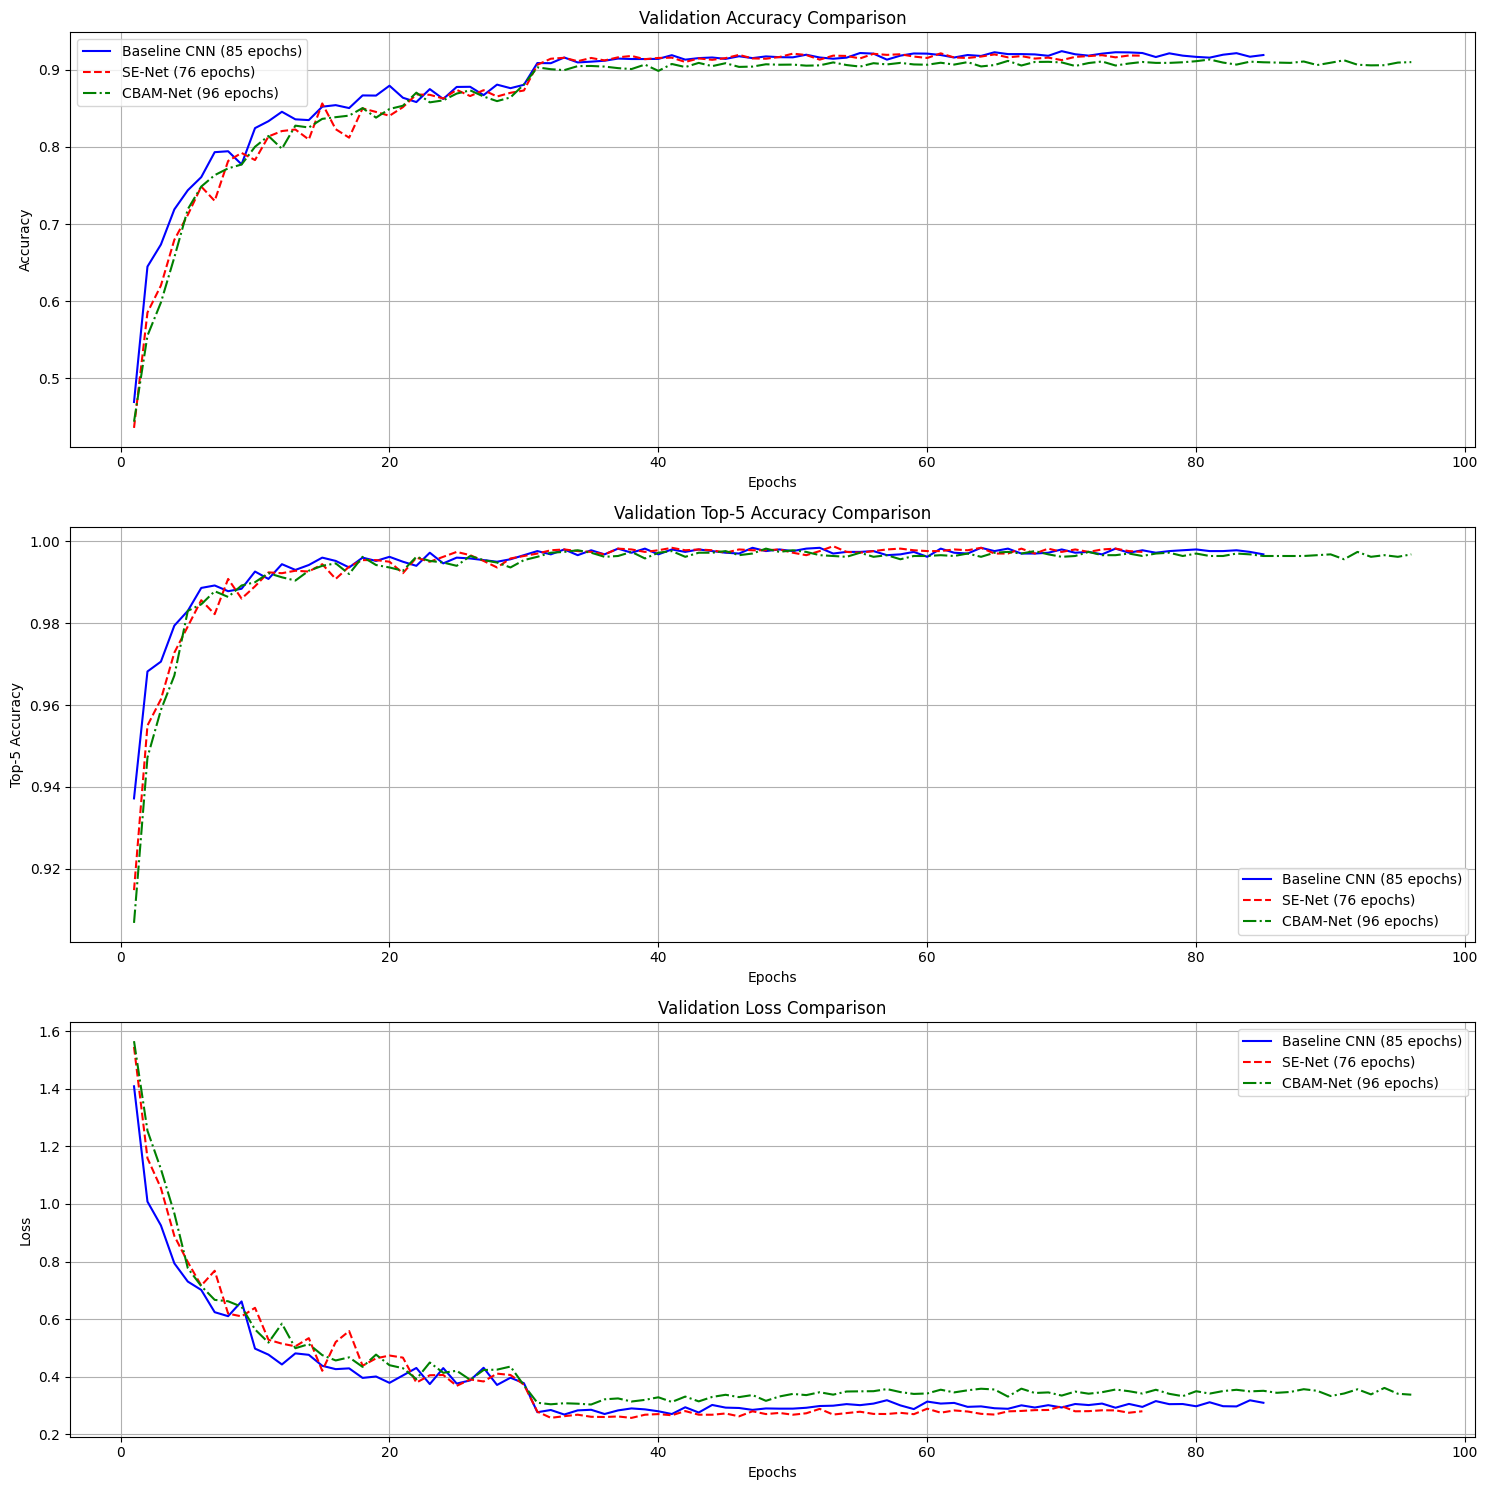


Final Performance Comparison:
Model | Val acc | Val top5_acc | Val loss | Epochs
----------------------------------------------------------------------------------------------------
Baseline CNN | 0.9192 | 0.9968 | 0.3098 | 85
SE-Net | 0.9184 | 0.9974 | 0.2805 | 76
CBAM-Net | 0.9100 | 0.9968 | 0.3379 | 96
Training epochs per model: {'Baseline CNN': 85, 'SE-Net': 76, 'CBAM-Net': 96}


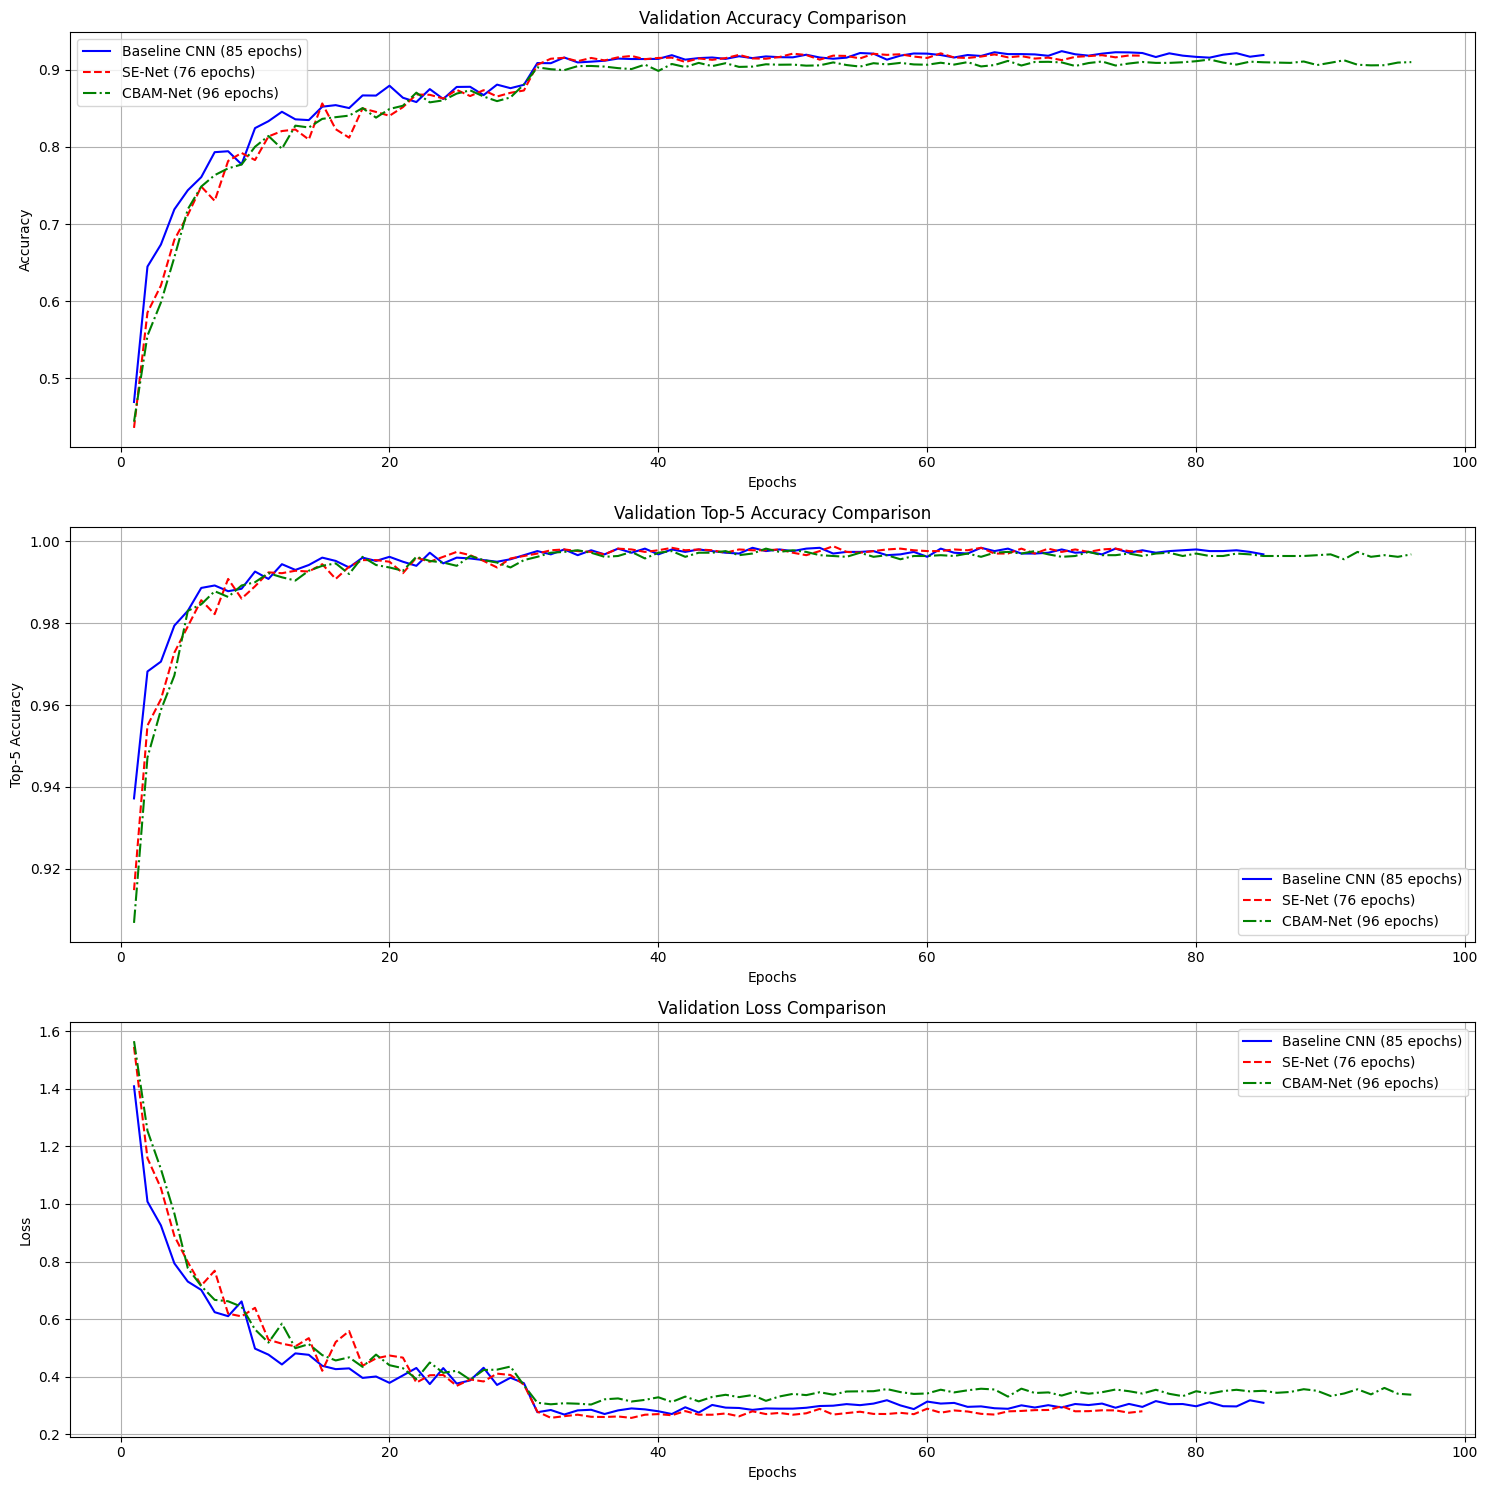


Final Performance Comparison:
Model | Val acc | Val top5_acc | Val loss | Epochs
----------------------------------------------------------------------------------------------------
Baseline CNN | 0.9192 | 0.9968 | 0.3098 | 85
SE-Net | 0.9184 | 0.9974 | 0.2805 | 76
CBAM-Net | 0.9100 | 0.9968 | 0.3379 | 96


In [28]:
# Fix your existing code
compare_models(
    models_history={
        'Baseline CNN': baseline_history,
        'SE-Net': se_history,
        'CBAM-Net': cbam_history
    },
    metrics=['acc', 'top5_acc', 'loss'],
    save_path=plot_dir
)

# OR use the new helper function
histories = combine_histories(
    [baseline_history, se_history, cbam_history],
    ["Baseline CNN", "SE-Net", "CBAM-Net"]
)
compare_models(histories, metrics=['acc', 'top5_acc', 'loss'], save_path=plot_dir)

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import torch.nn.functional as F


def visualize_attention_maps(model, data_loader, device, class_names, num_images=4, save_path=None):
    """
    Visualizes attention maps from SE-Net or CBAM-Net models.
    
    Args:
        model: The model with attention mechanisms
        data_loader: Data loader to get sample images
        device: Device to run the model on
        class_names: Names of the classes
        num_images: Number of images to visualize
        save_path: Path to save the visualizations
    """
    # Check if model has attention map support
    if not hasattr(model, 'attention_maps') and not hasattr(model, 'get_attention_maps'):
        print("This model doesn't support attention map visualization")
        return
    
    model.eval()
    model = model.to(device)
    
    # Get sample images
    images, labels = next(iter(data_loader))
    images = images[:num_images].to(device)
    labels = labels[:num_images].cpu().numpy()
    
    # Run forward pass to get attention maps
    with torch.no_grad():
        # Reset attention maps if they exist
        if hasattr(model, 'attention_maps'):
            model.attention_maps = []
        
        # Get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        
        # Get attention maps
        attention_maps = []
        if hasattr(model, 'attention_maps') and len(model.attention_maps) > 0:
            attention_maps = model.attention_maps
        elif hasattr(model, 'get_attention_maps'):
            # This would be for models where maps need to be explicitly extracted
            attention_maps = model.get_attention_maps()
    
    if not attention_maps:
        print("No attention maps generated")
        return
    
    # Get the number of attention maps to show
    num_maps = min(4, len(attention_maps))
    
    # Normalize images for display
    inv_normalize = transforms.Normalize(
        mean=[-0.4914/0.2470, -0.4822/0.2435, -0.4465/0.2616],
        std=[1/0.2470, 1/0.2435, 1/0.2616]
    )
    
    # Create figure
    fig = plt.figure(figsize=(15, 4 * num_images))
    
    for i in range(num_images):
        # Display original image
        ax = plt.subplot(num_images, num_maps + 1, i * (num_maps + 1) + 1)
        img = inv_normalize(images[i]).permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        title = f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}"
        plt.title(title)
        plt.axis('off')
        
        # Display attention maps
        for j in range(num_maps):
            ax = plt.subplot(num_images, num_maps + 1, i * (num_maps + 1) + j + 2)
            
            # Handle different attention map formats
            if j < len(attention_maps):
                if len(attention_maps[j].shape) == 4:  # [batch, channel, height, width]
                    att_map = attention_maps[j][i].sum(dim=0)  # Sum over channels
                elif len(attention_maps[j].shape) == 3:  # [batch, height, width]
                    att_map = attention_maps[j][i]
                else:
                    att_map = attention_maps[j].reshape(num_images, -1)[i].reshape(8, 8)
                
                plt.imshow(att_map.cpu().detach().numpy(), cmap='viridis')
                plt.title(f"Attention Layer {j+1}")
                plt.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}/attention_maps.png", dpi=300, bbox_inches='tight')
    plt.show()


def class_performance_analysis(models_dict, test_loader, device, class_names, save_path=None):
    """
    Analyzes and compares model performance on each class.
    
    Args:
        models_dict: Dictionary of {model_name: model}
        test_loader: Test data loader
        device: Device to run the models on
        class_names: Names of the classes
        save_path: Path to save the visualizations
    """
    results = {}
    
    # Evaluate each model
    for model_name, model in models_dict.items():
        model.eval()
        model = model.to(device)
        
        # Initialize class-wise metrics
        class_correct = np.zeros(len(class_names))
        class_total = np.zeros(len(class_names))
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                # Update class-wise metrics
                for i in range(len(labels)):
                    label = labels[i].item()
                    class_total[label] += 1
                    if preds[i].item() == label:
                        class_correct[label] += 1
        
        # Calculate class-wise accuracy
        class_accuracy = class_correct / class_total
        results[model_name] = class_accuracy
    
    # Plot results
    plt.figure(figsize=(12, 6))
    bar_width = 0.8 / len(models_dict)
    
    for i, (model_name, accuracies) in enumerate(results.items()):
        x = np.arange(len(class_names)) + i * bar_width
        plt.bar(x, accuracies * 100, width=bar_width, label=model_name)
    
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Performance Comparison')
    plt.xticks(np.arange(len(class_names)) + bar_width * (len(models_dict) - 1) / 2, class_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}/class_performance.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print performance improvement statistics
    if len(results) > 1:
        baseline_model = list(results.keys())[0]
        print(f"Class-wise Performance Improvement (compared to {baseline_model}):")
        print("Class | " + " | ".join([f"{name}" for name in results.keys()[1:]]))
        print("-" * 50)
        
        for i, class_name in enumerate(class_names):
            baseline_acc = results[baseline_model][i]
            improvements = []
            
            for model_name in list(results.keys())[1:]:
                model_acc = results[model_name][i]
                improvement = (model_acc - baseline_acc) / baseline_acc * 100
                improvements.append(f"{improvement:+.2f}%")
            
            print(f"{class_name} | " + " | ".join(improvements))
    
    return results


def analyze_misclassifications(models_dict, test_loader, device, class_names, num_samples=10, save_path=None):
    """
    Analyzes misclassifications across different models to find interesting patterns.
    
    Args:
        models_dict: Dictionary of {model_name: model}
        test_loader: Test data loader
        device: Device to run the models on
        class_names: Names of the classes
        num_samples: Number of misclassified samples to show
        save_path: Path to save the visualizations
    """
    model_predictions = {}
    
    # Get predictions from each model
    for model_name, model in models_dict.items():
        model.eval()
        model = model.to(device)
        
        all_preds = []
        all_labels = []
        all_images = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_images.extend(inputs.cpu())
                
                # Limit collection to save memory
                if len(all_labels) > 1000:
                    break
        
        model_predictions[model_name] = {
            'preds': np.array(all_preds),
            'labels': np.array(all_labels),
            'images': all_images
        }
    
    # Find interesting misclassifications
    baseline_model = list(models_dict.keys())[0]
    baseline_correct = model_predictions[baseline_model]['preds'] == model_predictions[baseline_model]['labels']
    
    interesting_cases = []
    case_types = []
    
    # Case 1: Baseline wrong, but attention models correct
    for i in range(len(baseline_correct)):
        if len(interesting_cases) >= num_samples:
            break
            
        # Skip if baseline was correct
        if baseline_correct[i]:
            continue
        
        # Check if any attention model got it right
        attention_correct = False
        for model_name in list(models_dict.keys())[1:]:
            if model_predictions[model_name]['preds'][i] == model_predictions[model_name]['labels'][i]:
                attention_correct = True
                break
        
        if attention_correct:
            interesting_cases.append(i)
            case_types.append("Baseline wrong, attention model correct")
    
    # Case 2: Baseline correct, but attention models wrong
    if len(interesting_cases) < num_samples:
        for i in range(len(baseline_correct)):
            if len(interesting_cases) >= num_samples:
                break
                
            # Skip if baseline was wrong or already included
            if not baseline_correct[i] or i in interesting_cases:
                continue
            
            # Check if all attention models got it wrong
            attention_all_wrong = True
            for model_name in list(models_dict.keys())[1:]:
                if model_predictions[model_name]['preds'][i] == model_predictions[model_name]['labels'][i]:
                    attention_all_wrong = False
                    break
            
            if attention_all_wrong:
                interesting_cases.append(i)
                case_types.append("Baseline correct, attention models wrong")
    
    # Visualize interesting cases
    if interesting_cases:
        # Normalize images for display
        inv_normalize = transforms.Normalize(
            mean=[-0.4914/0.2470, -0.4822/0.2435, -0.4465/0.2616],
            std=[1/0.2470, 1/0.2435, 1/0.2616]
        )
        
        num_cases = len(interesting_cases)
        num_models = len(models_dict)
        
        plt.figure(figsize=(4 * num_models, 4 * num_cases))
        
        for i, case_idx in enumerate(interesting_cases):
            true_label = model_predictions[baseline_model]['labels'][case_idx]
            
            for j, model_name in enumerate(models_dict.keys()):
                ax = plt.subplot(num_cases, num_models, i * num_models + j + 1)
                
                # Get image and prediction
                img = model_predictions[model_name]['images'][case_idx]
                img = inv_normalize(img).permute(1, 2, 0).numpy()
                img = np.clip(img, 0, 1)
                
                pred = model_predictions[model_name]['preds'][case_idx]
                
                plt.imshow(img)
                correct = pred == true_label
                color = 'green' if correct else 'red'
                
                title = f"{model_name}\nTrue: {class_names[true_label]}\nPred: {class_names[pred]}"
                plt.title(title, color=color)
                plt.axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/misclassification_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print summary of case types
        print("Misclassification Analysis:")
        for case_type in set(case_types):
            count = case_types.count(case_type)
            print(f"- {case_type}: {count} cases")
    else:
        print("No interesting misclassification patterns found")


def visualize_feature_maps(model, data_loader, device, layer_names=None, num_images=1, num_features=16, save_path=None):
    """
    Visualizes feature maps from intermediate layers of a model.
    
    Args:
        model: The model to visualize
        data_loader: Data loader to get sample images
        device: Device to run the model on
        layer_names: List of layer names to visualize (if None, attempts to find convolutional layers)
        num_images: Number of images to visualize
        num_features: Number of feature maps to show per layer
        save_path: Path to save the visualizations
    """
    model.eval()
    model = model.to(device)
    
    # Get sample images
    images, labels = next(iter(data_loader))
    image = images[:num_images].to(device)
    
    # Dictionary to store feature maps
    feature_maps = {}
    
    # Hook function to extract feature maps
    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output.detach()
        return hook
    
    # Register hooks for extracting feature maps
    hooks = []
    
    if layer_names is None:
        # Attempt to find convolutional layers
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                hooks.append(module.register_forward_hook(hook_fn(name)))
    else:
        # Use specified layer names
        for name in layer_names:
            for n, module in model.named_modules():
                if name in n:
                    hooks.append(module.register_forward_hook(hook_fn(name)))
                    break
    
    # Forward pass to get feature maps
    with torch.no_grad():
        _ = model(image)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Visualize feature maps
    if not feature_maps:
        print("No feature maps captured. Check layer names.")
        return
    
    # Normalize images for display
    inv_normalize = transforms.Normalize(
        mean=[-0.4914/0.2470, -0.4822/0.2435, -0.4465/0.2616],
        std=[1/0.2470, 1/0.2435, 1/0.2616]
    )
    
    for img_idx in range(num_images):
        # Display original image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        
        img = inv_normalize(image[img_idx]).permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')
        
        # Display feature map counts
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.text(0.1, 0.5, "\n".join([f"{name}: {maps.shape[1]} feature maps" 
                                     for name, maps in feature_maps.items()]))
        plt.title("Feature Map Counts")
        
        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/feature_map_summary_image_{img_idx}.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Display feature maps for each layer
        for layer_name, feature_map in feature_maps.items():
            # Get feature maps for current image
            layer_maps = feature_map[img_idx]
            
            # Determine grid size
            grid_size = int(np.ceil(np.sqrt(min(num_features, layer_maps.shape[0]))))
            
            # Create figure
            plt.figure(figsize=(15, 15))
            plt.suptitle(f"Feature Maps - {layer_name}", fontsize=16)
            
            # Plot feature maps
            for i in range(min(num_features, layer_maps.shape[0])):
                plt.subplot(grid_size, grid_size, i + 1)
                plt.imshow(layer_maps[i].cpu().numpy(), cmap='viridis')
                plt.axis('off')
                plt.title(f"Channel {i}")
            
            plt.tight_layout(rect=[0, 0, 1, 0.97])
            if save_path:
                plt.savefig(f"{save_path}/feature_maps_{layer_name}_image_{img_idx}.png", dpi=300, bbox_inches='tight')
            plt.show()


def model_complexity_comparison(models_dict, input_size=(1, 3, 32, 32), device='cuda'):
    """
    Compares model complexity (parameters, FLOPs, inference time).
    
    Args:
        models_dict: Dictionary of {model_name: model}
        input_size: Input tensor size
        device: Device to run the models on
        
    Returns:
        DataFrame with model complexity metrics
    """
    import time
    import pandas as pd
    
    results = {
        'Model': [],
        'Parameters (M)': [],
        'Inference Time (ms)': [],
        'Inference Time Std (ms)': [],
        'Memory Usage (MB)': []
    }
    
    dummy_input = torch.randn(input_size).to(device)
    
    for model_name, model in models_dict.items():
        model.eval()
        model = model.to(device)
        
        # Count parameters
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        # Measure inference time (warm-up + measurement)
        times = []
        
        # Warm-up
        for _ in range(10):
            _ = model(dummy_input)
        
        # Measure
        for _ in range(100):
            torch.cuda.synchronize()
            start_time = time.time()
            _ = model(dummy_input)
            torch.cuda.synchronize()
            times.append((time.time() - start_time) * 1000)  # Convert to ms
        
        # Measure memory usage
        torch.cuda.reset_peak_memory_stats()
        _ = model(dummy_input)
        memory_usage = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MB
        
        # Store results
        results['Model'].append(model_name)
        results['Parameters (M)'].append(num_params / 1e6)
        results['Inference Time (ms)'].append(np.mean(times))
        results['Inference Time Std (ms)'].append(np.std(times))
        results['Memory Usage (MB)'].append(memory_usage)
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Print table
    print("\nModel Complexity Comparison:")
    print(df.to_string(index=False))
    
    # Create bar chart
    plt.figure(figsize=(12, 6))
    
    # Parameters
    plt.subplot(1, 3, 1)
    plt.bar(df['Model'], df['Parameters (M)'])
    plt.title('Parameters (M)')
    plt.xticks(rotation=45)
    
    # Inference time
    plt.subplot(1, 3, 2)
    plt.bar(df['Model'], df['Inference Time (ms)'])
    plt.title('Inference Time (ms)')
    plt.xticks(rotation=45)
    
    # Memory usage
    plt.subplot(1, 3, 3)
    plt.bar(df['Model'], df['Memory Usage (MB)'])
    plt.title('Memory Usage (MB)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return df

FileNotFoundError: [Errno 2] No such file or directory: 'attention_maps/attention_maps.png'

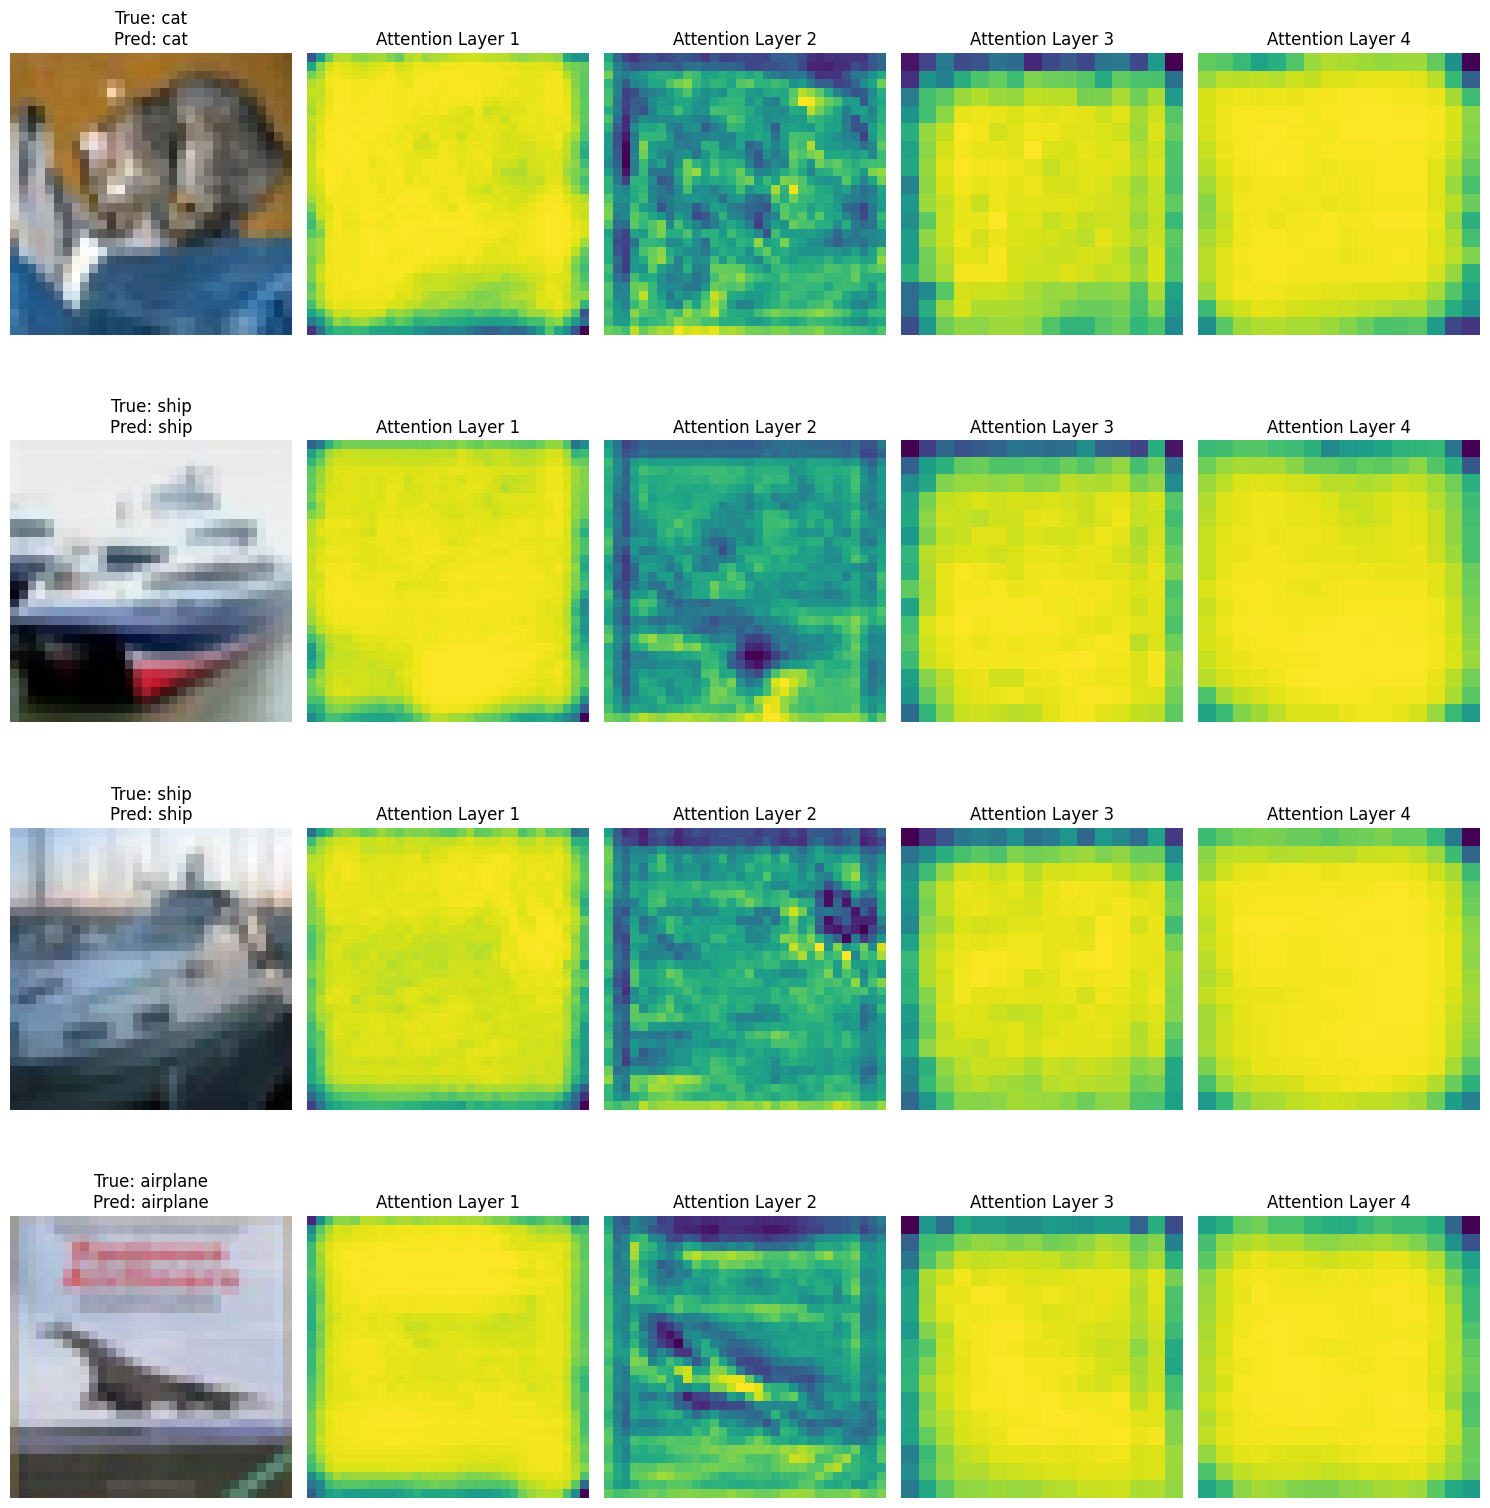

In [31]:
## SEBlock attention maps
visualize_attention_maps(cbam_model, testloader, device, class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], num_images=4, save_path='attention_maps')